This is needed to reload modules without restarting the kernel

In [93]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


This is needed to add eda_tools from the directories above

In [2]:
import os
os.sys.path.append('../../')

In [3]:
import uproot
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mplhep as hep
hep.set_style('ATLAS')

In [4]:
from eda_tools.utilities import getNorm

/mnt/storage/lborgna/condaenv/py36/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.unsupervised module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/mnt/storage/lborgna/condaenv/py36/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.tree.tree module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.tree. Anything that cannot be imported from sklearn.tree is now part of the private API.
  warnings.warn(message, FutureWarning)


In [5]:
from scipy.spatial.distance import euclidean

In [6]:
from hh4b_utils.nnt_tools import load_nnt

In [7]:
from eda_tools.bkg_helper import bs_error

In [8]:
from scipy.stats import wasserstein_distance

# Optimization Results analysis

### Let's define a function to calculate $\chi^2$

In [9]:
def weighted_chisquare(f_obs, f_exp, f_obs_err, f_exp_err, ignore_stats = False, residuals=False, stat_lim = 10):
    #obs = 2b
    #exp = 4b
    
    from scipy.stats import chi2
    
    
    #Calculate weighted chi-square using method in arXiv:physics/0605123
    if ignore_stats == False:
        w1 = f_obs[(f_obs > stat_lim) | (f_exp > stat_lim)]
        w2 = f_exp[(f_obs > stat_lim) | (f_exp > stat_lim)]
        s1 = f_obs_err[(f_obs > stat_lim) | (f_exp > stat_lim)]  # noqa
        s2 = f_exp_err[(f_obs > stat_lim) | (f_exp > stat_lim)]  # noqa
    else:
        w1 = f_obs
        w2 = f_exp
        s1 = f_obs_err # noqa
        s2 = f_exp_err # noqa
    
    ndf = len(w1) - 1
    W1 = np.sum(w1)  # noqa
    W2 = np.sum(w2)  # noqa

    pi = (w1*W1 / (s1**2)) + (w2*W2/ (s2**2)) / (((W1**2)/(s1**2)) + ((W2**2)/(s2**2)))


    R = (W1*w2 - W2*w1)**2 / (W1**2 * s2**2 + W2**2 * s1**2)
    R = np.where(((np.isnan(R)) | (np.isinf(R))), 0, R)
    #X2 = np.sum((W1*w2 - W2*w1)**2 / (W1**2 * s2**2 + W2**2 * s1**2))
    X2 = np.sum(R)
    p_value = chi2.sf(X2, ndf)
    if residuals:
        frac = 1 + ((W2**2)*(s1**2))/((W1**2)/(s2**2))
        top = w1-W1*pi
        bottom = s1 * np.sqrt(1 - 1/frac)
        ri = top/bottom
        return (X2, p_value, ndf, X2/ndf, ri)
    else:
        return (X2, p_value, ndf, X2/ndf)

### Define a function for the shape systematic (might be useful later)

In [10]:
def shape_systematic(
    df: pd.DataFrame,
    feature: str,
    kr: int,
    bins=50,
    hrange=None,
    CR_weights: str = None,
    VR_weights: str = None,
) -> dict:

    mask_2b = df["ntag"] == 2
    mask_kr = df["kinematic_region"] == kr

    if CR_weights is None:
        CR_weights = df.filter(regex="NN_d24_weight_bstrap_med").columns.to_list()[0]

    if VR_weights is None:
        VR_weights = df.filter(
            regex="NN_d24_weight_VRderiv_bstrap_med"
        ).columns.to_list()[0]

    mu_cr = getNorm(df, k=2, weight_column=CR_weights)
    mu_vr = getNorm(df, k=1, weight_column=VR_weights)

    x = df.loc[mask_2b & mask_kr, feature].values
    w_cr = df.loc[mask_2b & mask_kr, CR_weights].values
    w_vr = df.loc[mask_2b & mask_kr, VR_weights].values

    cr_estimate, be = np.histogram(x, bins=bins, range=hrange, weights=mu_cr * w_cr)

    vr_estimate, _ = np.histogram(
        x,
        bins=be,
        range=hrange,
        weights=mu_vr * w_vr,
    )

    inv_estimate, _ = np.histogram(
        x, bins=be, range=hrange, weights=2 * mu_cr * w_cr - mu_vr * w_vr
    )
    results = {}
    results['cr_estimate'] = cr_estimate
    results['vr_estimate'] = vr_estimate
    results['inv_estimate'] = inv_estimate
    results['shape_err'] = np.abs(vr_estimate - cr_estimate)
    results['be'] = be
    
    return results

### Nominal Histogram Generation

In [11]:
 def histogram_4b(
    df: pd.DataFrame, feature: str, kinematic_region: int, bins=50, hrange: tuple = None
) -> dict:

    mask_kr = df["kinematic_region"] == kinematic_region
    mask_4b = df["ntag"] >= 4

    h_4b, be = np.histogram(
        df.loc[mask_kr & mask_4b, feature].values, bins=bins, range=hrange
    )
    h_4b_err = np.sqrt(h_4b)  # Poisson error (sqrt(N))
    _results = {"h_4b": h_4b, "h_4b_err": h_4b_err, "be_4b": be}
    return _results

In [12]:
def histogram_2b(
    df: pd.DataFrame,
    feature: str,
    kinematic_region: int,
    norm: float,
    weights_column: str=None,
    bins: int = 50,
    hrange: tuple = None,
) -> dict:

    mask_kr = df["kinematic_region"] == kinematic_region
    mask_2b = df["ntag"] == 2

    x = df.loc[mask_kr & mask_2b, feature].values
    if weights_column is not None:
        w = norm * df.loc[mask_kr & mask_2b, weights_column].values
    else:
        w = np.ones(x.shape[0])

    h_2b, be = np.histogram(x, bins=bins, range=hrange, weights=w)
    
    if weights_column is not None:
        # Poisson error of a weighted histogram
        h_2b_err_pois = np.histogram(x, bins=bins, weights=w ** 2)[0]
    else:
        h_2b_err_pois = np.sqrt(h_2b)

    _results = {"h_2b": h_2b, "h_2b_err_pois": h_2b_err_pois, "be_2b": be}
    return _results

In [13]:
def generate_histograms(
    df: pd.DataFrame,
    features: list,
    bin_edges: list,
    norm: float,
    kinematic_region: int,
    weights_column: str,
) -> dict:

    histos_2b = np.array([])
    histos_4b = np.array([])
    error_2b = np.array([])
    error_4b = np.array([])
    emds = np.array([])
    for i, (feature, be) in enumerate(zip(features, bin_edges)):

        r4b = histogram_4b(
            df, feature=feature, kinematic_region=kinematic_region, bins=be
        )
        histos_4b = np.append(histos_4b, r4b["h_4b"])
        error_4b = np.append(error_4b, r4b["h_4b_err"])

        r2b = histogram_2b(
            df,
            feature=feature,
            kinematic_region=kinematic_region,
            norm=norm,
            weights_column=weights_column,
            bins=be,
        )
        histos_2b = np.append(histos_2b, r2b["h_2b"])
        error_2b = np.append(error_2b, r2b["h_2b_err_pois"])

        emd = wasserstein_distance(r4b["h_4b"], r2b["h_2b"])
        emds = np.append(emds, emd)
    return {
        "histos_2b": histos_2b,
        "histos_2b_poi_err": error_2b,
        "histos_4b": histos_4b,
        "histos_4b_poi_err": error_4b,
        "emds": emds,
    }

### Generating Error Histograms

In [14]:
def generate_bootstrap_errors(
    df: pd.DataFrame,
    features: list,
    bin_edges: list,
    kinematic_region: int,
    norm: float,
    norm_iqr: float,
    weights_column: str,
    weights_iqr: str,
) -> dict:

    bs_error_2b = np.array([])

    for i, (feature, be) in enumerate(zip(features, bin_edges)):
        bs_err = bs_error(
            df,
            kr=kinematic_region,
            be=be,
            mu_med=norm,
            mu_IQR=norm_iqr,
            W_med=weights_column,
            W_IQR=weights_iqr,
            feature=feature,
        )["h_err_bs_mag"]
        bs_error_2b = np.append(bs_error_2b, bs_err)

    return {"bs_err": bs_error_2b}

In [15]:
def generate_shape_systematic(
    df: pd.DataFrame,
    features: list,
    bin_edges: list,
    kinematic_region: int,
    weights_CR_column: str,
    weights_VR_column: str,
) -> dict:

    shape_syst_2b = np.array([])

    for i, (feature, be) in enumerate(zip(features, bin_edges)):
        shape_err = shape_systematic(
            df,
            feature = feature,
            kr = kinematic_region,
            bins = be,
            CR_weights= weights_CR_column,
            VR_weights= weights_VR_column
        )['shape_err']
        shape_syst_2b = np.append(shape_syst_2b, shape_err)
    return {"shape_err": shape_syst_2b}

### Analyze the reweighting

In [279]:
be = np.linspace(200, 1200, 51)

In [92]:
np.array(bin_edges)[0].shape

(51,)

In [281]:
be.shape

(51,)

In [17]:
def analyze_reweighting(
    df: pd.DataFrame,
    features: list,
    bin_edges: list,
    model_label: str = None,
    year: int = 16,
    verbose: bool = False,
) -> dict:

    labels = ["CRxCR", "VRxVR", "VRxCR", "CRxVR"]
    krs = [2, 1, 1, 2]
    model_region = ["CR", "VR", "CR", "VR"]

    chis2 = np.array([])
    chis2_bs = np.array([])
    chis2_shape = np.array([])

    emds = np.array([])
    if verbose:
        print("chis2: ", chis2)
        print("chis2: ", chis2_bs)
        print("chis2_shape: ", chis2_shape)
        print("emds: ", emds)

    h2b_all = np.array([])
    h4b_all = np.array([])
    error_2b_poi_all = np.array([])
    error_2b_bs_all = np.array([])
    error_2b_shape_all = np.array([])
    error_4b_poi_all = np.array([])

    for i, (l, kr, model_kr) in enumerate(zip(labels, krs, model_region)):
        if verbose:
            print(l)

        weight_cr_col = w_col(year, weight_label=model_label)
        weight_cr_iqr_col = w_iqr(year, weight_label=model_label)
        weight_vr_col = w_col(year, vr=True, weight_label=model_label)
        weight_vr_iqr_col = w_iqr(year, vr=True, weight_label=model_label)

        if model_kr == "CR":
            weight_column = weight_cr_col
            weights_iqr_col = weight_cr_iqr_col
            norm = get_norm(df, year, weight_label=model_label)
            mu_iqr = get_norm_iqr(df, year, weight_label=model_label)
            # norm = getNorm(df, k=2, weight_column=weight_column)
        elif model_kr == "VR":
            weight_column = weight_vr_col
            weights_iqr_col = weight_vr_iqr_col
            norm = get_norm(df, year, vr=True, weight_label=model_label)
            mu_iqr = get_norm_iqr(df, year=year, vr=True, weight_label=model_label)
            # norm = getNorm(df, k=1, weight_column=weight_column)

        histos = generate_histograms(
            df,
            features,
            bin_edges,
            norm,
            kinematic_region=kr,
            weights_column=weight_column,
        )
        if verbose:
            print("generated histos")
        bs_err = generate_bootstrap_errors(
            df,
            features,
            bin_edges,
            kinematic_region=kr,
            norm=norm,
            norm_iqr=mu_iqr,
            weights_column=weight_column,
            weights_iqr=weights_iqr_col,
        )
        if verbose:
            print("generated bs_error")
        shape_err = generate_shape_systematic(
            df,
            features,
            bin_edges,
            kinematic_region=kr,
            weights_CR_column=weight_cr_col,
            weights_VR_column=weight_vr_col,
        )
        if verbose:
            print("generated shape error")

        chi = weighted_chisquare(
            histos["histos_2b"],
            histos["histos_4b"],
            histos["histos_2b_poi_err"],
            histos["histos_4b_poi_err"],
        )[-1]

        chi_bs = weighted_chisquare(
            histos["histos_2b"],
            histos["histos_4b"],
            np.sqrt(histos["histos_2b_poi_err"] ** 2 + bs_err["bs_err"] ** 2),
            histos["histos_4b_poi_err"],
        )[-1]

        chi_shape = weighted_chisquare(
            histos["histos_2b"],
            histos["histos_4b"],
            np.sqrt(
                shape_err["shape_err"] ** 2
                + histos["histos_2b_poi_err"] ** 2
                + bs_err["bs_err"] ** 2
            ),
            histos["histos_4b_poi_err"],
        )[-1]

        h2b_all = np.append(h2b_all, histos["histos_2b"])
        h4b_all = np.append(h4b_all, histos["histos_4b"])
        error_2b_poi_all = np.append(error_2b_poi_all, histos["histos_2b_poi_err"])
        error_2b_bs_all = np.append(error_2b_bs_all, bs_err["bs_err"])
        error_2b_shape_all = np.append(error_2b_shape_all, shape_err["shape_err"])
        error_4b_poi_all = np.append(error_4b_poi_all, histos["histos_4b_poi_err"])

        emd_mean = histos["emds"].mean()
        emds = np.append(emds, emd_mean)

        chis2 = np.append(chis2, chi)
        chis2_bs = np.append(chis2_bs, chi_bs)
        chis2_shape = np.append(chis2_shape, chi_shape)

    ed = euclidean(chis2, np.ones(len(chis2)))
    ed_bs = euclidean(chis2_bs, np.ones(len(chis2_bs)))
    ed_shape = euclidean(chis2_shape, np.ones(len(chis2_shape)))
    ed_emd = euclidean(emds, np.zeros(len(emds)))

    chi2_all = weighted_chisquare(h2b_all, h4b_all, error_2b_poi_all, error_4b_poi_all)[
        -1
    ]
    chi2_bs_all = weighted_chisquare(
        h2b_all,
        h4b_all,
        np.sqrt(error_2b_bs_all ** 2 + error_2b_poi_all ** 2),
        error_4b_poi_all,
    )[-1]
    chi2_shape_all = weighted_chisquare(
        h2b_all,
        h4b_all,
        np.sqrt(error_2b_poi_all ** 2 + error_2b_bs_all ** 2 + error_2b_shape_all ** 2),
        error_4b_poi_all,
    )[-1]
    ### ONLY CR->CR and CR->VR results
    index_crcr = np.arange(0, be.shape[0] - 1)
    index_crvr = np.arange(3 * (be.shape[0] - 1), 4 * (be.shape[0] - 1))
    idx = np.append(index_crcr, index_crvr)
    chi2_2_all = weighted_chisquare(
        h2b_all[idx], h4b_all[idx], error_2b_poi_all[idx], error_4b_poi_all[idx]
    )[-1]
    chi2_2_bs_all = weighted_chisquare(
        h2b_all[idx],
        h4b_all[idx],
        np.sqrt(error_2b_bs_all[idx] ** 2 + error_2b_poi_all[idx] ** 2),
        error_4b_poi_all[idx],
    )[-1]
    chi2_2_shape_all = weighted_chisquare(
        h2b_all[idx],
        h4b_all[idx],
        np.sqrt(
            error_2b_poi_all[idx] ** 2
            + error_2b_bs_all[idx] ** 2
            + error_2b_shape_all[idx] ** 2
        ),
        error_4b_poi_all[idx],
    )[-1]

    ### ONLY CR->CR results
    idx = np.arange(0, be.shape[0] - 1)
    chi2_crcr_all = weighted_chisquare(
        h2b_all[idx], h4b_all[idx], error_2b_poi_all[idx], error_4b_poi_all[idx]
    )[-1]
    chi2_crcr_bs_all = weighted_chisquare(
        h2b_all[idx],
        h4b_all[idx],
        np.sqrt(error_2b_bs_all[idx] ** 2 + error_2b_poi_all[idx] ** 2),
        error_4b_poi_all[idx],
    )[-1]
    chi2_crcr_shape_all = weighted_chisquare(
        h2b_all[idx],
        h4b_all[idx],
        np.sqrt(
            error_2b_poi_all[idx] ** 2
            + error_2b_bs_all[idx] ** 2
            + error_2b_shape_all[idx] ** 2
        ),
        error_4b_poi_all[idx],
    )[-1]

    ### ONLY VR->VR results
    idx = np.arange(be.shape[0] - 1, 2 * (be.shape[0] - 1))
    chi2_vrvr_all = weighted_chisquare(
        h2b_all[idx], h4b_all[idx], error_2b_poi_all[idx], error_4b_poi_all[idx]
    )[-1]
    chi2_vrvr_bs_all = weighted_chisquare(
        h2b_all[idx],
        h4b_all[idx],
        np.sqrt(error_2b_bs_all[idx] ** 2 + error_2b_poi_all[idx] ** 2),
        error_4b_poi_all[idx],
    )[-1]
    chi2_vrvr_shape_all = weighted_chisquare(
        h2b_all[idx],
        h4b_all[idx],
        np.sqrt(
            error_2b_poi_all[idx] ** 2
            + error_2b_bs_all[idx] ** 2
            + error_2b_shape_all[idx] ** 2
        ),
        error_4b_poi_all[idx],
    )[-1]

    ### ONLY VR->CR results
    idx = np.arange(2 * (be.shape[0] - 1), 3 * (be.shape[0] - 1))
    chi2_vrcr_all = weighted_chisquare(
        h2b_all[idx], h4b_all[idx], error_2b_poi_all[idx], error_4b_poi_all[idx]
    )[-1]
    chi2_vrcr_bs_all = weighted_chisquare(
        h2b_all[idx],
        h4b_all[idx],
        np.sqrt(error_2b_bs_all[idx] ** 2 + error_2b_poi_all[idx] ** 2),
        error_4b_poi_all[idx],
    )[-1]
    chi2_vrcr_shape_all = weighted_chisquare(
        h2b_all[idx],
        h4b_all[idx],
        np.sqrt(
            error_2b_poi_all[idx] ** 2
            + error_2b_bs_all[idx] ** 2
            + error_2b_shape_all[idx] ** 2
        ),
        error_4b_poi_all[idx],
    )[-1]
    ### ONLY CR->VR results
    idx = np.arange(3 * (be.shape[0] - 1), 4 * (be.shape[0] - 1))
    chi2_crvr_all = weighted_chisquare(
        h2b_all[idx], h4b_all[idx], error_2b_poi_all[idx], error_4b_poi_all[idx]
    )[-1]
    chi2_crvr_bs_all = weighted_chisquare(
        h2b_all[idx],
        h4b_all[idx],
        np.sqrt(error_2b_bs_all[idx] ** 2 + error_2b_poi_all[idx] ** 2),
        error_4b_poi_all[idx],
    )[-1]
    chi2_crvr_shape_all = weighted_chisquare(
        h2b_all[idx],
        h4b_all[idx],
        np.sqrt(
            error_2b_poi_all[idx] ** 2
            + error_2b_bs_all[idx] ** 2
            + error_2b_shape_all[idx] ** 2
        ),
        error_4b_poi_all[idx],
    )[-1]

    results = {
        "chis2": chis2,
        "chis2_bs": chis2_bs,
        "chis2_shape": chis2_shape,
        "emds": emds,
        "ed": ed,
        "ed_bs": ed_bs,
        "ed_shape": ed_shape,
        "ed_emd": ed_emd,
        "chi2_all": chi2_all,
        "chi2_bs_all": chi2_bs_all,
        "chi2_shape_all": chi2_shape_all,
        "chi2_2_all": chi2_2_all,
        "chi2_2_bs_all": chi2_2_bs_all,
        "chi2_2_shape_all": chi2_2_shape_all,
        "chi2_crcr_all": chi2_crcr_all,
        "chi2_crcr_bs_all": chi2_crcr_bs_all,
        "chi2_crcr_shape_all": chi2_crcr_shape_all,
        "chi2_vrvr_all": chi2_vrvr_all,
        "chi2_vrvr_bs_all": chi2_vrvr_bs_all,
        "chi2_vrvr_shape_all": chi2_vrvr_shape_all,
        "chi2_vrcr_all": chi2_vrcr_all,
        "chi2_vrcr_bs_all": chi2_vrcr_bs_all,
        "chi2_vrcr_shape_all": chi2_vrcr_shape_all,
        "chi2_crvr_all": chi2_crvr_all,
        "chi2_crvr_bs_all": chi2_crvr_bs_all,
        "chi2_crvr_shape_all": chi2_crvr_shape_all,
        "labels": labels,
    }
    return results

### Helper Functions:

**Column Labels for Weights and IQR**

Context: In this particular weights dataframe the median normalization and IQR of norms are saved as a column in the dataframe filled with the same number for each event, so we just get the first entry in that column. Compression should take care of not exploding size too much.

In [18]:
def w_col(year: int, vr: bool = False, weight_label: str = None) -> str:
    """returns the nominal weight column name"""
    vr_prefix = "_VRderiv" if vr else ""
    weight_prefix = f"_{weight_label}" if weight_label is not None else ""
    return f"NN_d24_weight{vr_prefix}{weight_prefix}_bstrap_med_{year}"

def w_iqr(year: int, vr: bool = False, weight_label: str = None) -> str:
    """returns the nominal weights iqr column name"""
    vr_prefix = "_VRderiv" if vr else ""
    weight_prefix = f"_{weight_label}" if weight_label is not None else ""
    return f"NN_d24_weight{vr_prefix}{weight_prefix}_bstrap_IQR_{year}"
"""
def get_mu_iqr(file, year: int = 16, vr: bool = False) -> float:
    get nominal iqr of norms value from NNT
    vr_fix = "_VRderiv" if vr else ""
    return file[f"NN_norm{vr_fix}_bstrap_IQR_{year}"]._fVal
"""
def get_norm(df:pd.DataFrame, year:int=16, vr=False, weight_label:str=None)->float:
    vr_prefix = "_VRderiv" if vr else ""
    weight_prefix = f"_{weight_label}" if weight_label is not None else ""
    column = f'NN_norm{vr_prefix}{weight_prefix}_bstrap_med_{year}'
    norm = df[column][0]
    return norm
    
def get_norm_iqr(df:pd.DataFrame, year:int=16, vr=False, weight_label:str=None)->float:
    vr_prefix = "_VRderiv" if vr else ""
    weight_prefix = f"_{weight_label}" if weight_label is not None else ""
    column = f'NN_norm{vr_prefix}{weight_prefix}_bstrap_IQR_{year}'
    norm = df[column][0]
    return norm
    

### Constants: Features to use and bin ranges

In [19]:
features = ["m_hh", "X_wt_tag", "pt_hh", "dEta_hh"]
ranges = [(200, 1200), (1.5, 9), (0, 250), (0, 1.5)]
nbins = [50, 50, 50, 50]
bin_edges = []
for hrange, nb in zip(ranges, nbins):
    be = np.linspace(hrange[0], hrange[1], nb+1)
    bin_edges.append(be)

In [20]:
labels = ["CRxCR", "VRxVR", "VRxCR", "CRxVR"]
krs = [2, 1, 1, 2]
model_region = ["CR", "VR", "CR", "VR"]

### Loading Data 

In [21]:
!ls -lh /mnt/storage/lborgna/NNT/MDR_VEC/data/

total 36G
-rw-r--r-- 1 lborgna users 434M Apr  5 17:08 data_2B_SRshift_16.root
-rw-r--r-- 1 lborgna users 527M Apr  8 20:05 data_2B_SRshift_16_with_weights.root
-rw-r--r-- 1 lborgna users 404M Apr  5 17:17 data_2B_SRshift_17.root
-rw-r--r-- 1 lborgna users 478M Apr  8 20:06 data_2B_SRshift_17_with_weights.root
-rw-r--r-- 1 lborgna users 947M Apr  5 17:28 data_2B_SRshift_18.root
-rw-r--r-- 1 lborgna users 1.2G Apr  8 20:07 data_2B_SRshift_18_with_weights.root
-rw-r--r-- 1 lborgna users 4.0G Apr 16 15:04 data_2B_SRshift_fmp_16.root
-rw-r--r-- 1 lborgna users 3.8G Apr 20 17:58 data_2B_SRshift_fmp_17.root
-rw-r--r-- 1 lborgna users 8.6G Apr 20 18:08 data_2B_SRshift_fmp_18.root
-rw-r--r-- 1 lborgna users 421M Apr 14 11:06 data_CRVRSR_16.root
-rw-r--r-- 1 lborgna users 392M Apr 14 11:06 data_CRVRSR_17.root
-rw-r--r-- 1 lborgna users 915M Apr 14 11:08 data_CRVRSR_18.root
-rw-r--r-- 1 lborgna users 509M Apr 22 04:01 data_CRVRSR_2B_SRshift_16_NN_100_bootstraps.root
-rw-r--r-- 1 lborgna users 53

In [22]:
file_path_16 = "/mnt/storage/lborgna/NNT/MDR_VEC/data/data_CRVRSR_16.root"
# file_path_17 = "/mnt/storage/lborgna/NNT/MDR_VEC/data/data_CRVRSR_17.root"
# file_path_18 = "/mnt/storage/lborgna/NNT/MDR_VEC/data/data_CRVRSR_18.root"

In [79]:
df_test = load_nnt(file_path_16, columns=['m_hh'], trees=['sig'])

100%|██████████| 141/141 [00:12<00:00, 11.64it/s]


In [80]:
df_test.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 405795 entries, 0 to 405794
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   m_hh    405795 non-null  float32
dtypes: float32(1)
memory usage: 1.5 MB


In [23]:
df16 = load_nnt(file_path_16)
# df17 = load_nnt(file_path_17)
# df18 = load_nnt(file_path_18)

100%|██████████| 141/141 [00:26<00:00,  5.35it/s]


In [24]:
df16.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1965822 entries, 0 to 1965821
Data columns (total 89 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   run_number             int32  
 1   event_number           int64  
 2   pass_vbf_sel           bool   
 3   mc_sf                  float32
 4   trig_sf                float64
 5   jet_trig_sfs           float64
 6   truth_mhh              float64
 7   ntag                   int32  
 8   njets                  int32  
 9   kinematic_region       int8   
 10  m_min_dj               float32
 11  m_max_dj               float32
 12  pairing_score_1        float32
 13  pairing_score_2        float32
 14  bkt_lead_jet_pt        float64
 15  bkt_third_lead_jet_pt  float64
 16  bkt_HT                 float64
 17  bucket_passed          int32  
 18  cos_theta_star         float32
 19  m_hh_cor               float64
 20  m_hh                   float32
 21  pt_hh                  float32
 22  dEta_hh           

In [27]:
# for _df in [df16, df17, df18]:
#     print(_df.info(memory_usage='deep'))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1965822 entries, 0 to 1965821
Data columns (total 89 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   run_number             int32  
 1   event_number           int64  
 2   pass_vbf_sel           bool   
 3   mc_sf                  float32
 4   trig_sf                float64
 5   jet_trig_sfs           float64
 6   truth_mhh              float64
 7   ntag                   int32  
 8   njets                  int32  
 9   kinematic_region       int8   
 10  m_min_dj               float32
 11  m_max_dj               float32
 12  pairing_score_1        float32
 13  pairing_score_2        float32
 14  bkt_lead_jet_pt        float64
 15  bkt_third_lead_jet_pt  float64
 16  bkt_HT                 float64
 17  bucket_passed          int32  
 18  cos_theta_star         float32
 19  m_hh_cor               float64
 20  m_hh                   float32
 21  pt_hh                  float32
 22  dEta_hh           

### Loading weights 

In [25]:
!ls -lh /mnt/storage/lborgna/NNT/MDR_VEC/data/optimization/combined_weights*

-rw-r--r-- 1 lborgna users 1.5G Apr 19 11:22 /mnt/storage/lborgna/NNT/MDR_VEC/data/optimization/combined_weights_16.h5
-rw-r--r-- 1 lborgna users 1.3G Apr 14 10:46 /mnt/storage/lborgna/NNT/MDR_VEC/data/optimization/combined_weights_17.h5
-rw-r--r-- 1 lborgna users 3.1G Apr 14 10:49 /mnt/storage/lborgna/NNT/MDR_VEC/data/optimization/combined_weights_18.h5
-rw-r--r-- 1 lborgna users 4.6G Apr 19 10:51 /mnt/storage/lborgna/NNT/MDR_VEC/data/optimization/combined_weights_min_16.h5
-rw-r--r-- 1 lborgna users 4.2G Apr 19 18:38 /mnt/storage/lborgna/NNT/MDR_VEC/data/optimization/combined_weights_min_17.h5
-rw-r--r-- 1 lborgna users 9.8G Apr 19 21:57 /mnt/storage/lborgna/NNT/MDR_VEC/data/optimization/combined_weights_min_18.h5


In [26]:
store = pd.HDFStore(
    "/mnt/storage/lborgna/NNT/MDR_VEC/data/optimization/combined_weights_min_16.h5"
)

In [27]:
df_w = store['df']

In [28]:
df_w.head(1)

event_number  run_number  ntag  kinematic_region  pass_vbf_sel  \
0       1216190      298773     2                 2         False   

   NN_d24_weight_M0F0T0_bstrap_med_16  NN_d24_weight_M0F0T0_bstrap_IQR_16  \
0                            0.003241                            0.001453   

   NN_norm_M0F0T0_bstrap_med_16  NN_norm_M0F0T0_bstrap_IQR_16  \
0                      1.049556                      0.098456   

   NN_d24_weight_VRderiv_M0F0T0_bstrap_med_16  ...  \
0                                    0.001921  ...   

   NN_norm_M24F0T0_bstrap_med_16  NN_norm_M24F0T0_bstrap_IQR_16  \
0                       1.017419                       0.010755   

   NN_d24_weight_VRderiv_M25F0T0_bstrap_med_16  \
0                                     0.004665   

   NN_d24_weight_VRderiv_M25F0T0_bstrap_IQR_16  \
0                                     0.000803   

   NN_norm_VRderiv_M25F0T0_bstrap_med_16  \
0                               1.090062   

   NN_norm_VRderiv_M25F0T0_bstrap_IQR_16  NN_d24_weight_M25F0T0_bstrap_med_16  \
0                               0.032713                             0.004409   

   NN_d24_weight_M25F0T0_bstrap_IQR_16  NN_norm_M25F0T0_bstrap_med_16  \
0                             0.001167                       1.070414   

   NN_norm_M25F0T0_bstrap_IQR_16  
0                       0.016443  

[1 rows x 325 columns]

In [29]:
models_keys_16 = store.get_storer('df').attrs.model_labels

In [30]:
df16 = df16.merge(
    df_w.drop(columns=["ntag", "kinematic_region", "pass_vbf_sel"]),
    on=["event_number", "run_number"],
    how="inner",
)

In [31]:
df16.shape

(1908423, 409)

In [32]:
df16.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1908423 entries, 0 to 1908422
Columns: 409 entries, run_number to NN_norm_M25F0T0_bstrap_IQR_16
dtypes: bool(7), float32(51), float64(340), int32(4), int64(1), int8(6)
memory usage: 5.3 GB


In [34]:
store.close()

**DUE TO CONCERNS OF HIGH RAM MEMORY USAGE WITH MORE YEARS LETS JUST TRY TO PROCEED WITH 2016 ONLY FOR NOW**

# Calculate it for the different models

# MAIN RESULTS LOOP

In [35]:
model_types = 23*['NN_nominal'] + 3 * ['NN_classifier'] + 14 * ['XGB']

In [36]:
for i, (m, m_t) in enumerate(zip(models_keys_16, model_types)):
    print(i, m, m_t)

0 M0F0T0 NN_nominal
1 M0F1T0 NN_nominal
2 M0F2T0 NN_nominal
3 M0F3T0 NN_nominal
4 M0F4T0 NN_nominal
5 M0F5T0 NN_nominal
6 M1F0T0 NN_nominal
7 M1F0T1 NN_nominal
8 M1F0T2 NN_nominal
9 M1F0T3 NN_nominal
10 M1F0T4 NN_nominal
11 M1F1T0 NN_nominal
12 M2F1T0 NN_nominal
13 M3F0T0 NN_nominal
14 M4F0T0 NN_nominal
15 M5F0T0 NN_nominal
16 M6F0T0 NN_nominal
17 M7F0T0 NN_nominal
18 M8F0T0 NN_nominal
19 M9F0T0 NN_nominal
20 M10F0T0 NN_nominal
21 M11F0T0 NN_nominal
22 M12F0T0 NN_nominal
23 M13F0T0 NN_classifier
24 M14F0T0 NN_classifier
25 M15F0T0 NN_classifier
26 M20F0T0 XGB
27 M20F0T1 XGB
28 M20F0T2 XGB
29 M20F1T2 XGB
30 M20F2T2 XGB
31 M21F0T0 XGB
32 M21F2T2 XGB
33 M21F3T2 XGB
34 M21F4T2 XGB
35 M21F5T2 XGB
36 M22F0T0 XGB
37 M23F0T0 XGB
38 M24F0T0 XGB
39 M25F0T0 XGB


In [37]:
chis = {}
chis_bs = {}
chis_shape = {}
ed = {}
ed_bs = {}
ed_shape = {}
ed_emd = {}
chis2_all = {}
chis2_bs_all = {}
chis2_shape_all = {}
emds = {}

chi2_2_all = {}
chi2_2_bs_all = {}
chi2_2_shape_all = {}
chi2_crcr_all = {}
chi2_crcr_bs_all = {}
chi2_crcr_shape_all = {}
chi2_vrvr_all = {}
chi2_vrvr_bs_all = {}
chi2_vrvr_shape_all = {}
chi2_vrcr_all = {}
chi2_vrcr_bs_all = {}
chi2_vrcr_shape_all = {}
chi2_crvr_all = {}
chi2_crvr_bs_all = {}
chi2_crvr_shape_all = {}

for i, model in enumerate(models_keys_16):
    print(i, model)
    model_results = analyze_reweighting(df16, features, bin_edges, model, verbose= False)
    chis[model] = model_results['chis2']
    chis_bs[model] = model_results['chis2_bs']
    chis_shape[model] = model_results['chis2_shape']
    ed[model] = model_results['ed']
    ed_bs[model] = model_results['ed_bs']
    ed_shape[model] = model_results['ed_shape']
    ed_emd[model] = model_results['ed_emd']
    chis2_all[model] = model_results['chi2_all']
    chis2_bs_all[model] = model_results['chi2_bs_all']
    chis2_shape_all[model] = model_results['chi2_shape_all']
    emds[model] = model_results['emds']
    
    chi2_2_all[model] = model_results['chi2_2_all']
    chi2_2_bs_all[model] = model_results['chi2_2_bs_all']
    chi2_2_shape_all[model] = model_results['chi2_2_shape_all']
    chi2_crcr_all[model] = model_results['chi2_crcr_all']
    chi2_crcr_bs_all[model] = model_results['chi2_crcr_bs_all']
    chi2_crcr_shape_all[model] = model_results['chi2_crcr_shape_all']
    chi2_vrvr_all[model] = model_results['chi2_vrvr_all']
    chi2_vrvr_bs_all[model] = model_results['chi2_vrvr_bs_all']
    chi2_vrvr_shape_all[model] = model_results['chi2_vrvr_shape_all']
    chi2_vrcr_all[model] = model_results['chi2_vrcr_all']
    chi2_vrcr_bs_all[model] =model_results['chi2_vrcr_bs_all']
    chi2_vrcr_shape_all[model] = model_results['chi2_vrcr_shape_all']
    chi2_crvr_all[model] = model_results['chi2_crvr_all']
    chi2_crvr_bs_all[model] = model_results['chi2_crvr_bs_all']
    chi2_crvr_shape_all[model] = model_results['chi2_crvr_bs_all']
    

0 M0F0T0
1 M0F1T0
2 M0F2T0
3 M0F3T0
4 M0F4T0
5 M0F5T0
6 M1F0T0
7 M1F0T1
8 M1F0T2
9 M1F0T3
10 M1F0T4
11 M1F1T0
12 M2F1T0
13 M3F0T0
14 M4F0T0
15 M5F0T0
16 M6F0T0
17 M7F0T0
18 M8F0T0
19 M9F0T0
20 M10F0T0
21 M11F0T0
22 M12F0T0
23 M13F0T0
24 M14F0T0
25 M15F0T0
26 M20F0T0
27 M20F0T1
28 M20F0T2
29 M20F1T2
30 M20F2T2
31 M21F0T0
32 M21F2T2
33 M21F3T2
34 M21F4T2
35 M21F5T2
36 M22F0T0
37 M23F0T0
38 M24F0T0
39 M25F0T0


In [335]:
model_results

{'chis2': array([1.29130254, 1.04290924, 1.17949503, 1.39134531]),
 'chis2_bs': array([1.24131309, 1.00058545, 1.15350494, 1.2939316 ]),
 'chis2_shape': array([0.80195021, 0.89714242, 0.95557667, 0.88567314]),
 'emds': array([ 7.22773302,  5.35579265,  5.27972792, 12.65884198]),
 'ed': 0.5216013686210383,
 'ed_bs': 0.4101120645345574,
 'ed_shape': 0.2546516535223913,
 'ed_emd': 16.402635358417538,
 'chi2_all': 1.2674323652460369,
 'chi2_bs_all': 1.2118430147933243,
 'chi2_shape_all': 0.8913407889279662,
 'chi2_2_all': 1.6261610551011452,
 'chi2_2_bs_all': 1.5817296551362945,
 'chi2_2_shape_all': 1.0444136453576003,
 'chi2_crcr_all': 2.2777414783250745,
 'chi2_crcr_bs_all': 2.1845529195291973,
 'chi2_crcr_shape_all': 1.4245850983858004,
 'chi2_vrvr_all': 0.9568901791462889,
 'chi2_vrvr_bs_all': 0.925172116709195,
 'chi2_vrvr_shape_all': 0.4946725209293694,
 'chi2_vrcr_all': 0.996770428172021,
 'chi2_vrcr_bs_all': 0.9180534490906601,
 'chi2_vrcr_shape_all': 0.6025053705153818,
 'chi2_crv

In [100]:
chis2_all.values()

dict_values([1.6197475927828997, 2.05892124208364, 1.6361838154102444, 2.233066173119899, 2.3129599544719195, 2.505117512546358, 1.796476222600565, 1.7836692356922814, 1.9694902371818463, 2.2098331541238356, 1.6153133089643998, 1.9110071669902426, 1.9832594203149163, 1.739431637102562, 1.6843624253988836, 1.5486149861233354, 1.4820401518147117, 1.8124977485742604, 1.3786439857556723, 6.4574947585447955, 2.7884656871411244, 1.6616407380550904, 1.7643916956818204, 1.4392629991601453, 1.4143995180903512, 1.4866207858014773, 1.2907642995757742, 1.1773961544164115, 1.1592311788269727, 1.8039142889476665, 1.1220860059893978, 2.642586969759896, 2.620883290091743, 2.6811391776596576, 2.780372024717029, 2.7515278176241704, 2.4545460527185154, 2.404428103966645, 1.2061735434920833, 1.2674323652460369])

In [45]:
opt_data = pd.DataFrame(
    {
        "model_key": models_keys_16,
        "model_type": model_types,
        "chis2_all": chis2_all.values(),
        "chis2_bs_all": chis2_bs_all.values(),
        "chis_shape_all": chis2_shape_all.values(),
        "chis":chis.values(),
        "chis_bs": chis_bs.values(),
        "chis_shape":chis_shape.values(),
        "ed": ed.values(),
        "ed_bs":ed_bs.values(),
        "ed_shape":ed_shape.values(),
        "ed_emd": ed_emd.values(),
        "chi2_2_all": chi2_2_all.values(),
        "chi2_2_bs_all":chi2_2_bs_all.values(),
        "chi2_2_shape_all":chi2_2_shape_all.values(),
        "chi2_crcr_all":chi2_crcr_all.values(),
        "chi2_crcr_bs_all":chi2_crcr_bs_all.values(),
        "chi2_crcr_shape_all":chi2_crcr_shape_all.values(),
        "chi2_vrvr_all":chi2_vrvr_all.values(),
        "chi2_vrvr_bs_all":chi2_vrvr_bs_all.values(),
        "chi2_vrvr_shape_all":chi2_vrvr_shape_all.values(),
        "chi2_crvr_all":chi2_crvr_all.values(),
        "chi2_crvr_bs_all":chi2_crvr_bs_all.values(),
        "chi2_crvr_shape_all":chi2_crvr_shape_all.values(),
        "chi2_vrcr_all":chi2_vrcr_all.values(),
        "chi2_vrcr_bs_all":chi2_vrcr_bs_all.values(),
        "chi2_vrcr_shape_all":chi2_vrcr_shape_all.values(),
    }
)

In [97]:
chis2_all

{'M0F0T0': 1.6197475927828997,
 'M0F1T0': 2.05892124208364,
 'M0F2T0': 1.6361838154102444,
 'M0F3T0': 2.233066173119899,
 'M0F4T0': 2.3129599544719195,
 'M0F5T0': 2.505117512546358,
 'M1F0T0': 1.796476222600565,
 'M1F0T1': 1.7836692356922814,
 'M1F0T2': 1.9694902371818463,
 'M1F0T3': 2.2098331541238356,
 'M1F0T4': 1.6153133089643998,
 'M1F1T0': 1.9110071669902426,
 'M2F1T0': 1.9832594203149163,
 'M3F0T0': 1.739431637102562,
 'M4F0T0': 1.6843624253988836,
 'M5F0T0': 1.5486149861233354,
 'M6F0T0': 1.4820401518147117,
 'M7F0T0': 1.8124977485742604,
 'M8F0T0': 1.3786439857556723,
 'M9F0T0': 6.4574947585447955,
 'M10F0T0': 2.7884656871411244,
 'M11F0T0': 1.6616407380550904,
 'M12F0T0': 1.7643916956818204,
 'M13F0T0': 1.4392629991601453,
 'M14F0T0': 1.4143995180903512,
 'M15F0T0': 1.4866207858014773,
 'M20F0T0': 1.2907642995757742,
 'M20F0T1': 1.1773961544164115,
 'M20F0T2': 1.1592311788269727,
 'M20F1T2': 1.8039142889476665,
 'M20F2T2': 1.1220860059893978,
 'M21F0T0': 2.642586969759896,
 'M

In [52]:
len(opt_data['chis'][0])

4

In [53]:
opt_data.to_pickle('opt_data_16.pkl')

In [58]:
!ls -lh opt_*

-rw-r--r-- 1 lborgna users 17K Apr 27 14:51 opt_data_16.pkl
-rw-r--r-- 1 lborgna users 15K Apr 19 22:17 opt_data_17.pkl
-rw-r--r-- 1 lborgna users 15K Apr 19 22:42 opt_data_18.pkl


In [99]:
opt_data['chis'].shape

(40,)

## Analysis of Results

In [60]:
opt_data = pd.read_pickle('opt_data_16.pkl')

In [61]:
opt_data

model_key     model_type  chis2_all  chis2_bs_all  chis_shape_all  \
0     M0F0T0     NN_nominal   1.619748      1.399317        0.952291   
1     M0F1T0     NN_nominal   2.058921      1.767068        1.007881   
2     M0F2T0     NN_nominal   1.636184      1.533505        0.940167   
3     M0F3T0     NN_nominal   2.233066      1.711329        0.976991   
4     M0F4T0     NN_nominal   2.312960      1.975804        0.992425   
5     M0F5T0     NN_nominal   2.505118      2.023084        1.107704   
6     M1F0T0     NN_nominal   1.796476      1.620804        1.162034   
7     M1F0T1     NN_nominal   1.783669      1.670903        1.212404   
8     M1F0T2     NN_nominal   1.969490      1.876986        1.300077   
9     M1F0T3     NN_nominal   2.209833      2.023561        1.304097   
10    M1F0T4     NN_nominal   1.615313      1.499239        1.110885   
11    M1F1T0     NN_nominal   1.911007      1.768363        1.217379   
12    M2F1T0     NN_nominal   1.983259      1.599800        1.096744   
13    M3F0T0     NN_nominal   1.739432      1.511145        0.899007   
14    M4F0T0     NN_nominal   1.684362      1.414630        0.875136   
15    M5F0T0     NN_nominal   1.548615      1.497794        1.021337   
16    M6F0T0     NN_nominal   1.482040      1.282395        0.994305   
17    M7F0T0     NN_nominal   1.812498      1.533771        0.956819   
18    M8F0T0     NN_nominal   1.378644      1.086728        0.794754   
19    M9F0T0     NN_nominal   6.457495      3.593582        3.548065   
20   M10F0T0     NN_nominal   2.788466      2.207955        1.757714   
21   M11F0T0     NN_nominal   1.661641      1.574148        1.010553   
22   M12F0T0     NN_nominal   1.764392      1.651096        1.008601   
23   M13F0T0  NN_classifier   1.439263      1.363180        0.917226   
24   M14F0T0  NN_classifier   1.414400      1.316398        0.932372   
25   M15F0T0  NN_classifier   1.486621      1.349219        0.990627   
26   M20F0T0            XGB   1.290764      1.228035        0.900385   
27   M20F0T1            XGB   1.177396      1.128256        0.812939   
28   M20F0T2            XGB   1.159231      1.095714        0.801663   
29   M20F1T2            XGB   1.803914      1.706940        1.014780   
30   M20F2T2            XGB   1.122086      1.068444        0.697064   
31   M21F0T0            XGB   2.642587      2.422736        1.523133   
32   M21F2T2            XGB   2.620883      2.222193        1.289688   
33   M21F3T2            XGB   2.681139      2.198703        1.298486   
34   M21F4T2            XGB   2.780372      2.143637        1.291299   
35   M21F5T2            XGB   2.751528      2.351614        1.323876   
36   M22F0T0            XGB   2.454546      2.311188        1.424656   
37   M23F0T0            XGB   2.404428      2.226442        1.371558   
38   M24F0T0            XGB   1.206174      1.180393        0.879144   
39   M25F0T0            XGB   1.267432      1.211843        0.891341   

                                                 chis  \
0   [1.38945221705387, 1.211973147583116, 1.161534...   
1   [1.634919689078518, 1.260831009763985, 1.29508...   
2   [1.2273495667114807, 1.2183929679584953, 1.611...   
3   [1.500988213157045, 1.444919310753073, 1.46321...   
4   [1.4351991448218444, 1.4037748139011592, 1.336...   
5   [1.642151416508145, 1.4133383336014, 1.2150617...   
6   [1.588009620099657, 1.3461071319538276, 1.1602...   
7   [1.6378578129923227, 1.3247363306547588, 1.213...   
8   [1.7752747923441157, 1.408771109767006, 1.1984...   
9   [1.866230717308948, 1.5982937637312122, 1.2562...   
10  [1.5023323269308542, 1.1996222728752548, 1.163...   
11  [1.584410356383955, 1.3479664527089636, 1.2282...   
12  [1.633621975796783, 1.4122400675399704, 1.2049...   
13  [1.3204819247612938, 1.299958635538364, 1.0836...   
14  [1.3212348643467076, 1.2562825169921175, 1.177...   
15  [1.377156369886712, 1.194642988936662, 1.17220...   
16  [1.3084379755692672, 1.1617890230065946, 1.028...   
17  [1.5121063279618325,

### Poisson Only Results $\chi^2$  

In [66]:
chis2_all.values()

dict_values([1.6197475927828997, 2.05892124208364, 1.6361838154102444, 2.233066173119899, 2.3129599544719195, 2.505117512546358, 1.796476222600565, 1.7836692356922814, 1.9694902371818463, 2.2098331541238356, 1.6153133089643998, 1.9110071669902426, 1.9832594203149163, 1.739431637102562, 1.6843624253988836, 1.5486149861233354, 1.4820401518147117, 1.8124977485742604, 1.3786439857556723, 6.4574947585447955, 2.7884656871411244, 1.6616407380550904, 1.7643916956818204, 1.4392629991601453, 1.4143995180903512, 1.4866207858014773, 1.2907642995757742, 1.1773961544164115, 1.1592311788269727, 1.8039142889476665, 1.1220860059893978, 2.642586969759896, 2.620883290091743, 2.6811391776596576, 2.780372024717029, 2.7515278176241704, 2.4545460527185154, 2.404428103966645, 1.2061735434920833, 1.2674323652460369])

In [104]:
set(model_types)

{'NN_classifier', 'NN_nominal', 'XGB'}

In [120]:
chis2_all_df = pd.DataFrame({"model_key": chis2_all.keys(), "chi2":chis2_all.values()})

In [130]:
chis2_all_df.sort_values(by='chi2',ascending=True, inplace =True)

In [131]:
chis2_all_df.iloc[0][0]

'M20F2T2'

In [123]:
chis2_all_df['model_key'][0]

'M0F0T0'

In [176]:
chis2_all['M0F0T0']

1.6197475927828997

In [39]:
def plot_models(model_list:list, metric:list, title='Model performance',baseline:float=None):
    fig, ax = plt.subplots(figsize=(16,6))
    nn_nominal_count=0
    nn_classifier_count=0
    xgb_count=0
    for i, (k, v) in enumerate(zip(model_list, metric)):
        if model_types[i] == 'NN_nominal':
            if nn_nominal_count == 0:
                ax.plot(k, v, 'o', color = 'red', label = 'NN_nominal')
                nn_nominal_count+=1
            else:
                ax.plot(k, v, 'o', color='red')
        elif model_types[i] == 'NN_classifier':
            if nn_classifier_count==0:
                ax.plot(k, v, 'o', color = 'green', label ='NN_classifier')
                nn_classifier_count+=1
            else:
                ax.plot(k, v, 'o', color = 'green')
        elif model_types[i] == 'XGB':
            if xgb_count==0:
                ax.plot(k, v, 'o', color = 'indigo', label = 'XGB')
                xgb_count+=1
            else:
                plt.plot(k, v, 'o', color='indigo')
    results = pd.DataFrame({"model_key": model_list, "metric": metric})
    results['diff'] = np.abs(1-results['metric'])
    results.sort_values(by='diff', ascending=True,inplace=True)
    ax.plot(results.iloc[0,0], results.iloc[0, 1], '*', markersize=24, markeredgecolor='gold', markerfacecolor='none', label = 'Best Result')
    ax.axhline(1, color='black', ls ='--', label = '$\chi^2 = 1$')
    if baseline is not None:
        ax.axhline(baseline, label = 'Baseline', ls = "--")
    ax.set_title(title)
    ax.set_ylabel(r'$\chi^2$')
    ax.set_xlabel('model key')
    ax.set_xticklabels(model_list, rotation=90)

    ax.legend()
    
    return {"results_df":results,
           "fig":fig,
           "ax": ax}


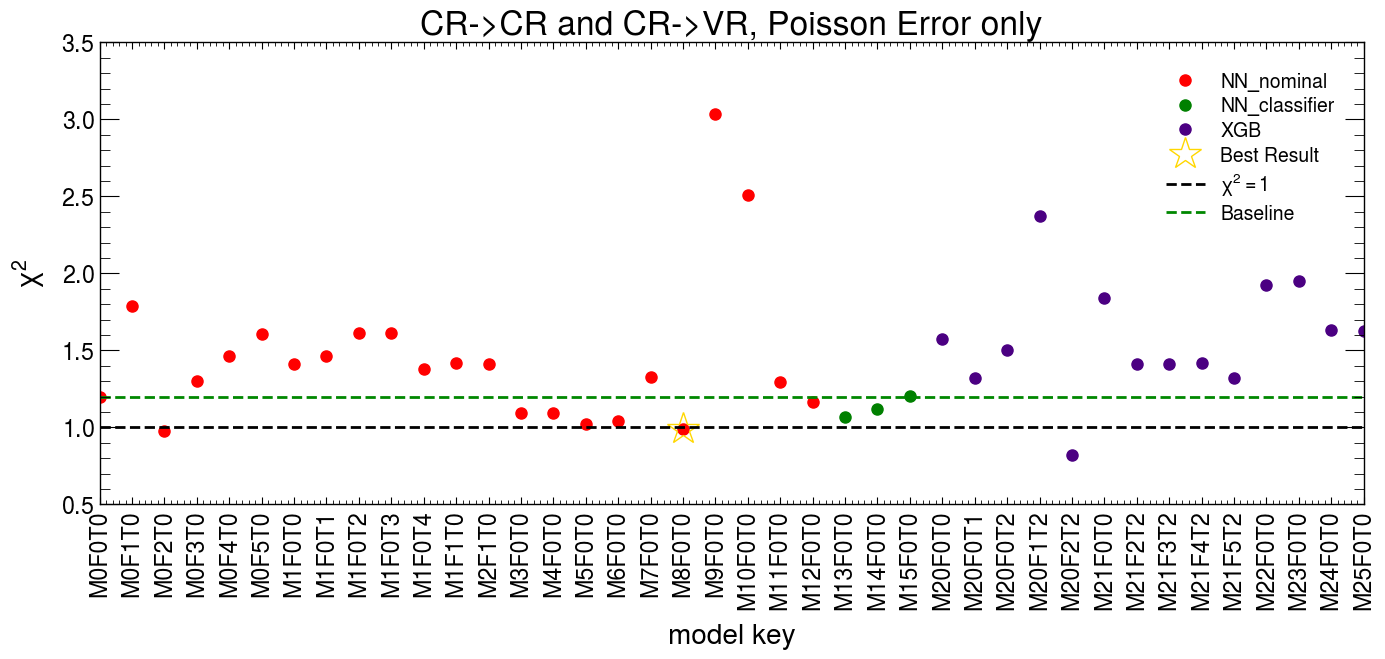

In [54]:
results = plot_models(
    chi2_2_all.keys(),
    chi2_2_all.values(),
    baseline=chi2_2_all["M0F0T0"],
    title="CR->CR and CR->VR, Poisson Error only",
    
)

In [77]:
results['results_df']

model_key    metric      diff
26   M20F0T0  0.995039  0.004961
39   M25F0T0  1.044414  0.044414
29   M20F1T2  1.051836  0.051836
37   M23F0T0  0.912537  0.087463
20   M10F0T0  1.094851  0.094851
36   M22F0T0  0.895931  0.104069
38   M24F0T0  1.115788  0.115788
28   M20F0T2  0.879777  0.120223
8     M1F0T2  0.853215  0.146785
31   M21F0T0  0.821570  0.178430
27   M20F0T1  0.802680  0.197320
11    M1F1T0  0.802328  0.197672
7     M1F0T1  0.801733  0.198267
9     M1F0T3  0.800197  0.199803
19    M9F0T0  0.786283  0.213717
12    M2F1T0  0.750763  0.249237
10    M1F0T4  0.732362  0.267638
6     M1F0T0  0.666593  0.333407
32   M21F2T2  0.654836  0.345164
25   M15F0T0  0.609890  0.390110
1     M0F1T0  0.588353  0.411647
21   M11F0T0  0.579200  0.420800
5     M0F5T0  0.576727  0.423273
22   M12F0T0  0.576237  0.423763
33   M21F3T2  0.573031  0.426969
16    M6F0T0  0.572253  0.427747
30   M20F2T2  0.569872  0.430128
35   M21F5T2  0.565752  0.434248
24   M14F0T0  0.563551  0.436449
34   M21F4T2  0.559773  0.440227
23   M13F0T0  0.550704  0.449296
4     M0F4T0  0.546424  0.453576
15    M5F0T0  0.529853  0.470147
17    M7F0T0  0.520763  0.479237
18    M8F0T0  0.514420  0.485580
0     M0F0T0  0.510592  0.489408
3     M0F3T0  0.506322  0.493678
2     M0F2T0  0.503791  0.496209
14    M4F0T0  0.478333  0.521667
13    M3F0T0  0.467563  0.532437

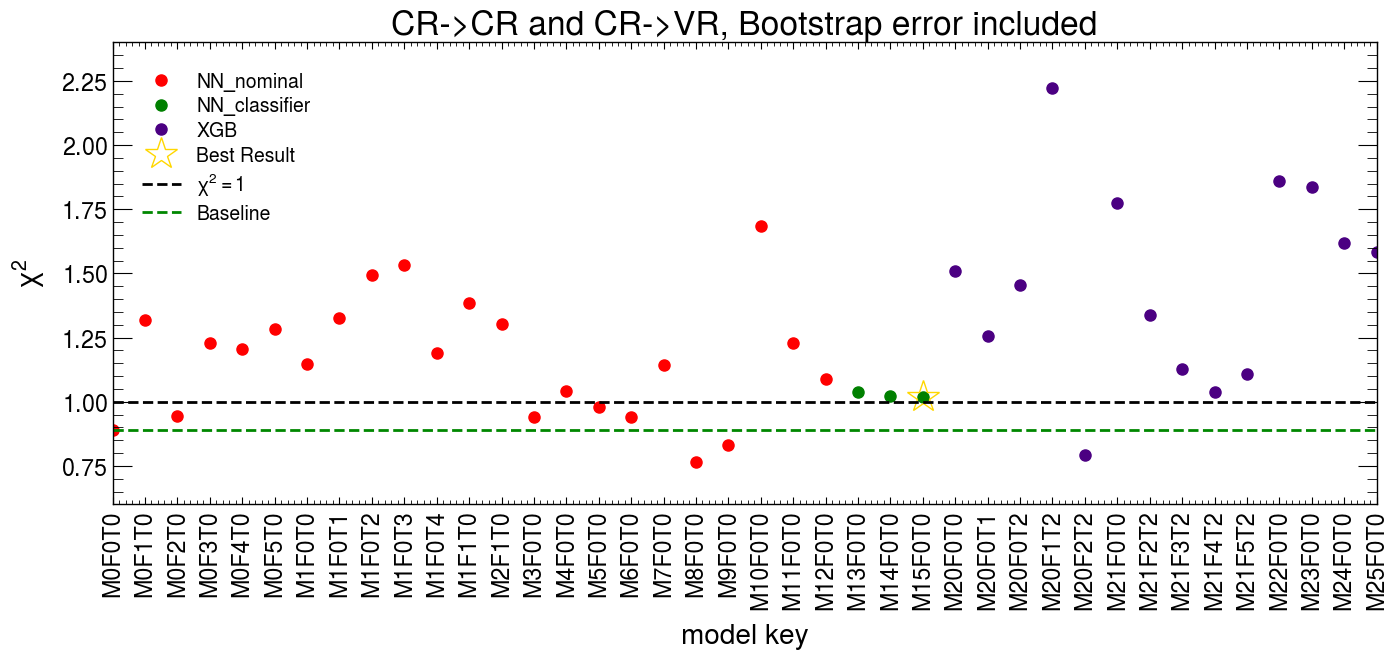

In [55]:
results = plot_models(chi2_2_bs_all.keys(), chi2_2_bs_all.values(),baseline=chi2_2_bs_all['M0F0T0'], title = 'CR->CR and CR->VR, Bootstrap error included')

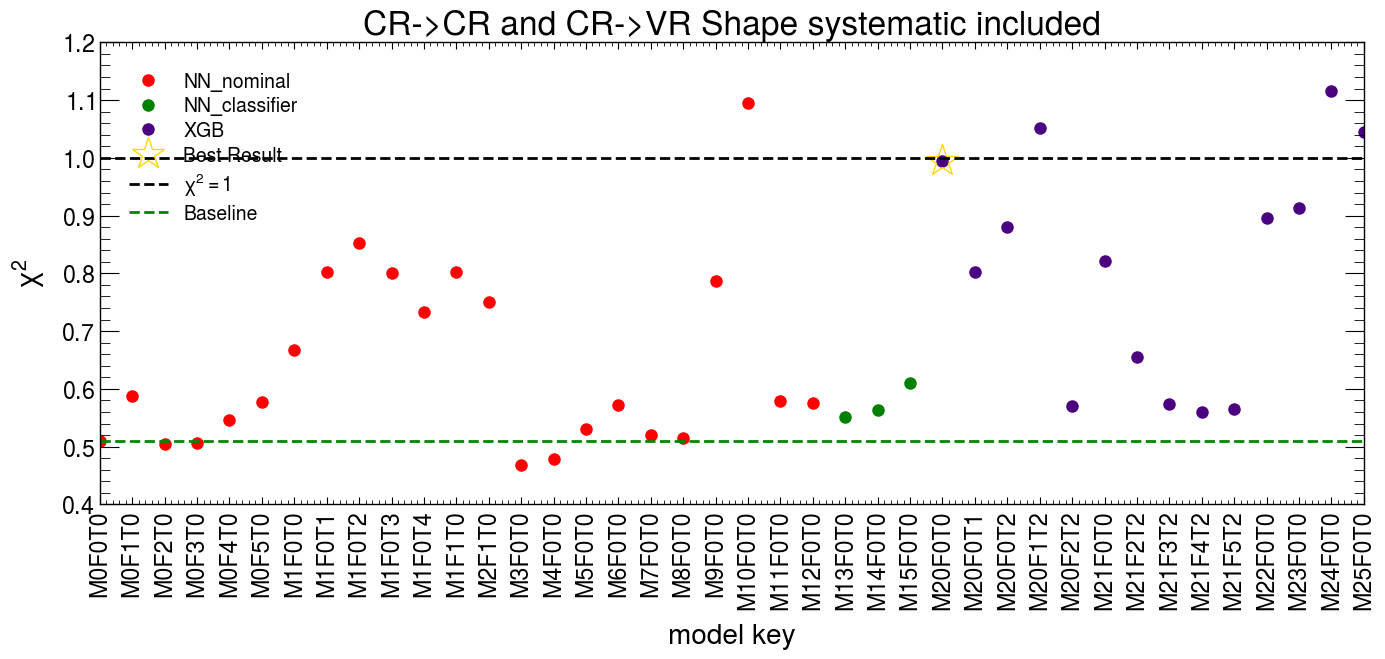

In [57]:
results = plot_models(
    chi2_2_shape_all.keys(),
    chi2_2_shape_all.values(),
    baseline=chi2_2_shape_all["M0F0T0"],
    title="CR->CR and CR->VR Shape systematic included",
)

In [67]:
opt_data['model_key'].values

array(['M0F0T0', 'M0F1T0', 'M0F2T0', 'M0F3T0', 'M0F4T0', 'M0F5T0',
       'M1F0T0', 'M1F0T1', 'M1F0T2', 'M1F0T3', 'M1F0T4', 'M1F1T0',
       'M2F1T0', 'M3F0T0', 'M4F0T0', 'M5F0T0', 'M6F0T0', 'M7F0T0',
       'M8F0T0', 'M9F0T0', 'M10F0T0', 'M11F0T0', 'M12F0T0', 'M13F0T0',
       'M14F0T0', 'M15F0T0', 'M20F0T0', 'M20F0T1', 'M20F0T2', 'M20F1T2',
       'M20F2T2', 'M21F0T0', 'M21F2T2', 'M21F3T2', 'M21F4T2', 'M21F5T2',
       'M22F0T0', 'M23F0T0', 'M24F0T0', 'M25F0T0'], dtype=object)

In [69]:
opt_data.loc[opt_data['model_key']=='M0F0T0', 'chi2_2_shape_all']

0    0.510592
Name: chi2_2_shape_all, dtype: float64

(0.3, 1.4)

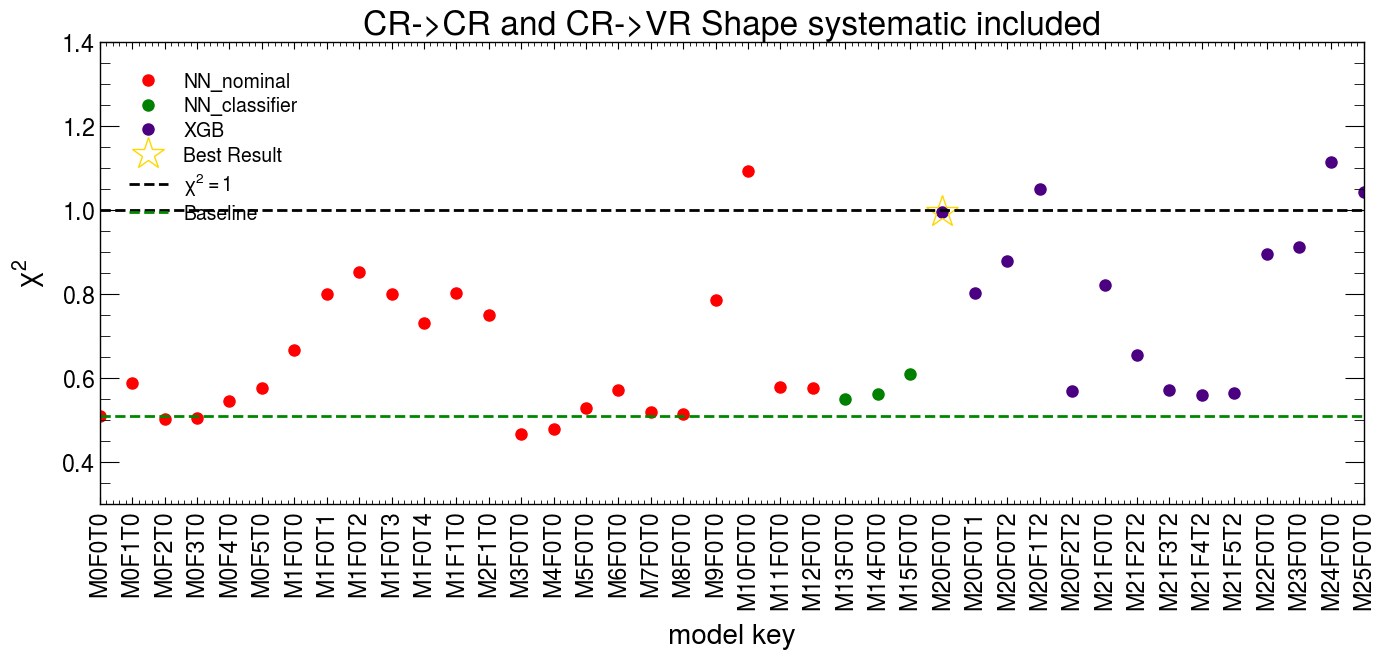

In [76]:
results = plot_models(
    opt_data['model_key'].values,
    opt_data.chi2_2_shape_all.values,
    baseline=opt_data.loc[opt_data['model_key']=='M0F0T0','chi2_2_shape_all'].values,
    title="CR->CR and CR->VR Shape systematic included",
)
results['ax'].set_ylim(0.3, 1.4)


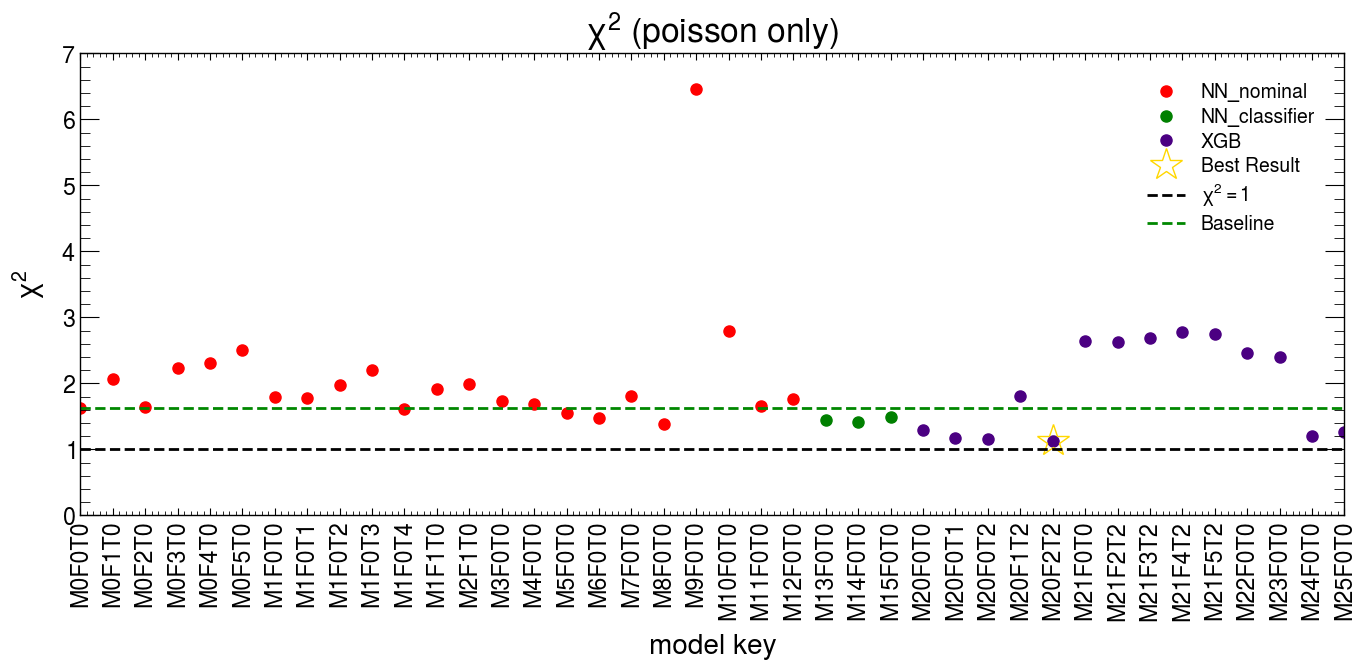

In [177]:
plt.subplots(figsize=(16,6))
nn_nominal_count=0
nn_classifier_count=0
xgb_count=0
for i, (k, v) in enumerate(chis2_all.items()):
    if model_types[i] == 'NN_nominal':
        if nn_nominal_count == 0:
            plt.plot(k, v, 'o', color = 'red', label = 'NN_nominal')
            nn_nominal_count+=1
        else:
            plt.plot(k, v, 'o', color='red')
    elif model_types[i] == 'NN_classifier':
        if nn_classifier_count==0:
            plt.plot(k, v, 'o', color = 'green', label ='NN_classifier')
            nn_classifier_count+=1
        else:
            plt.plot(k, v, 'o', color = 'green')
    elif model_types[i] == 'XGB':
        if xgb_count==0:
            plt.plot(k, v, 'o', color = 'indigo', label = 'XGB')
            xgb_count+=1
            
        else:
            plt.plot(k, v, 'o', color='indigo')
plt.plot(chis2_all_df.iloc[0,0], chis2_all_df.iloc[0, 1], '*', markersize=24, markeredgecolor='gold', markerfacecolor='none', label = 'Best Result')
plt.axhline(1, color='black', ls ='--', label = '$\chi^2 = 1$')
plt.axhline(chis2_all["M0F0T0"], label = 'Baseline', ls = "--")
plt.title(r'$\chi^2$ (poisson only)')
plt.ylabel(r'$\chi^2$')
plt.xlabel('model key')
_=plt.xticks(rotation=90)
plt.legend()

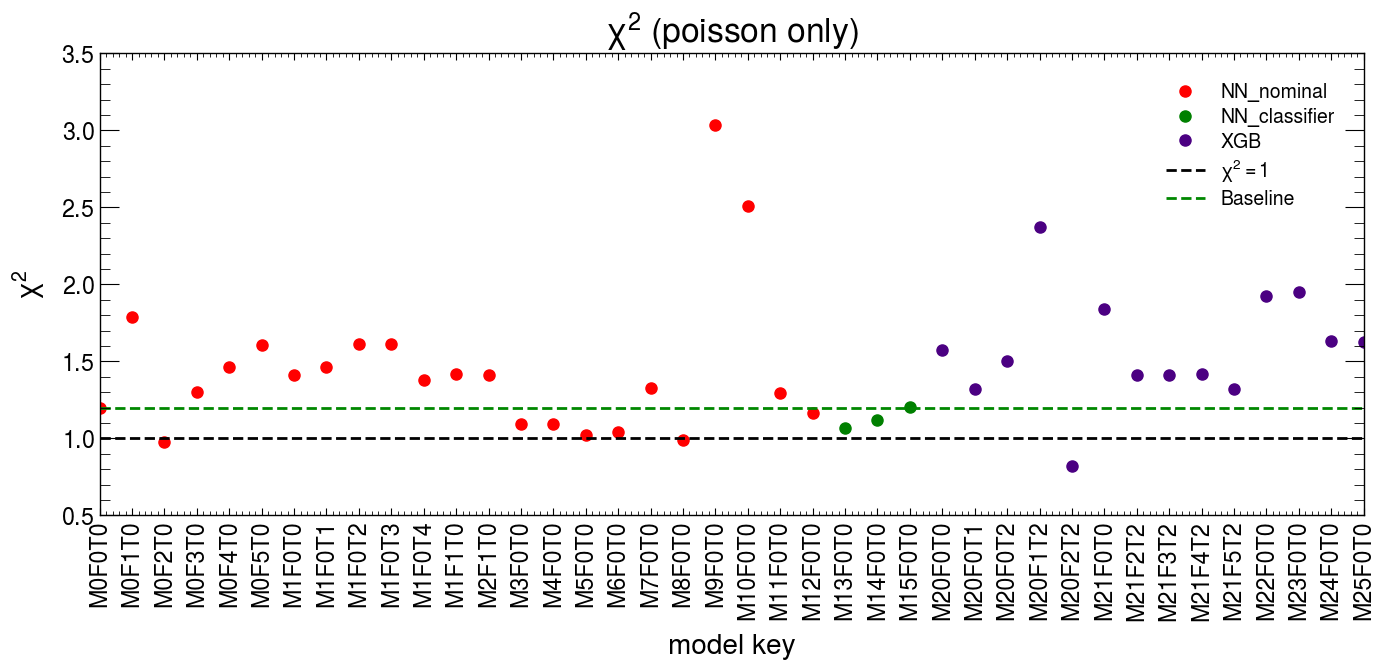

In [339]:
plt.subplots(figsize=(16,6))
nn_nominal_count=0
nn_classifier_count=0
xgb_count=0
for i, (k, v) in enumerate(chi2_2_all.items()):
    if model_types[i] == 'NN_nominal':
        if nn_nominal_count == 0:
            plt.plot(k, v, 'o', color = 'red', label = 'NN_nominal')
            nn_nominal_count+=1
        else:
            plt.plot(k, v, 'o', color='red')
    elif model_types[i] == 'NN_classifier':
        if nn_classifier_count==0:
            plt.plot(k, v, 'o', color = 'green', label ='NN_classifier')
            nn_classifier_count+=1
        else:
            plt.plot(k, v, 'o', color = 'green')
    elif model_types[i] == 'XGB':
        if xgb_count==0:
            plt.plot(k, v, 'o', color = 'indigo', label = 'XGB')
            xgb_count+=1
        else:
            plt.plot(k, v, 'o', color='indigo')
#plt.plot(chis2_2_all_df.iloc[0,0], chis2_all_df.iloc[0, 1], '*', markersize=24, markeredgecolor='gold', markerfacecolor='none', label = 'Best Result')
plt.axhline(1, color='black', ls ='--', label = '$\chi^2 = 1$')
plt.axhline(chi2_2_all["M0F0T0"], label = 'Baseline', ls = "--")
plt.title(r'$\chi^2$ (poisson only)')
plt.ylabel(r'$\chi^2$')
plt.xlabel('model key')
_=plt.xticks(rotation=90)
plt.legend()

### Including Bootstrap Error in $\chi^2$

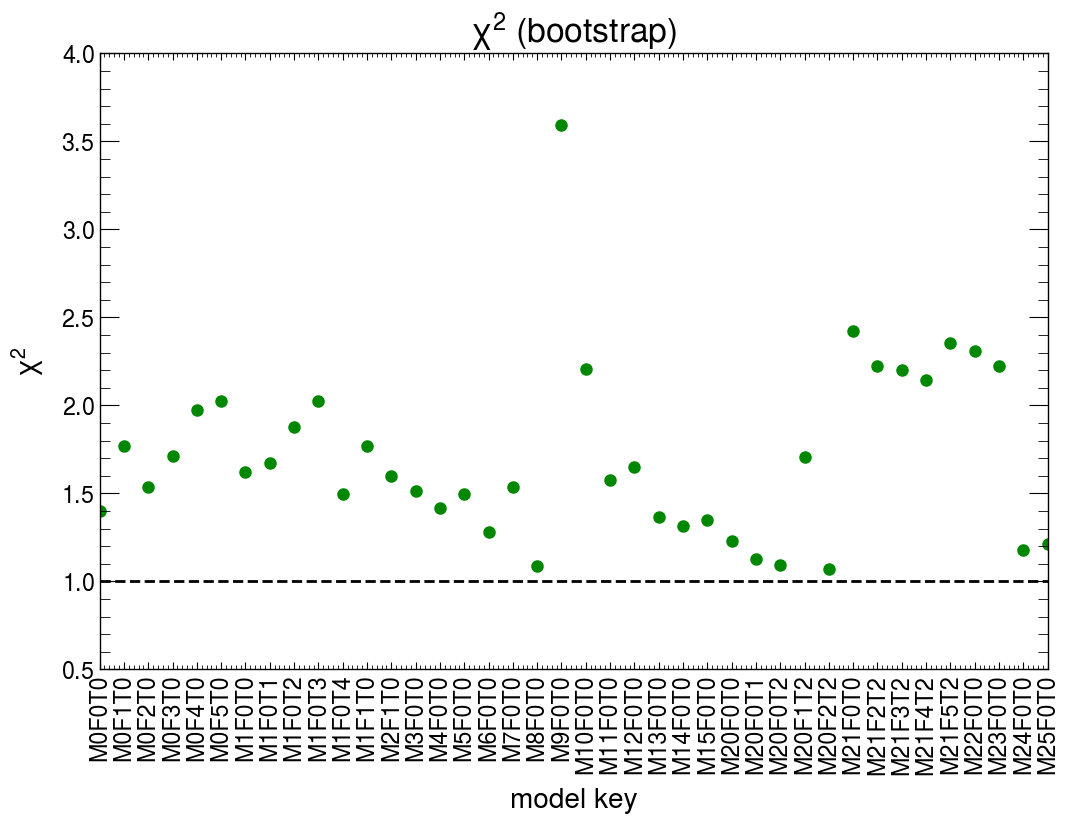

In [276]:
plt.subplots(figsize=(12, 8))
plt.plot(list(chis2_bs_all.keys()), list(chis2_bs_all.values()), 'o')
plt.axhline(1, color='black', ls = '--')
plt.title(r'$\chi^2$ (bootstrap)')
plt.ylabel(r'$\chi^2$')
plt.xlabel('model key')
_=plt.xticks(rotation=90)

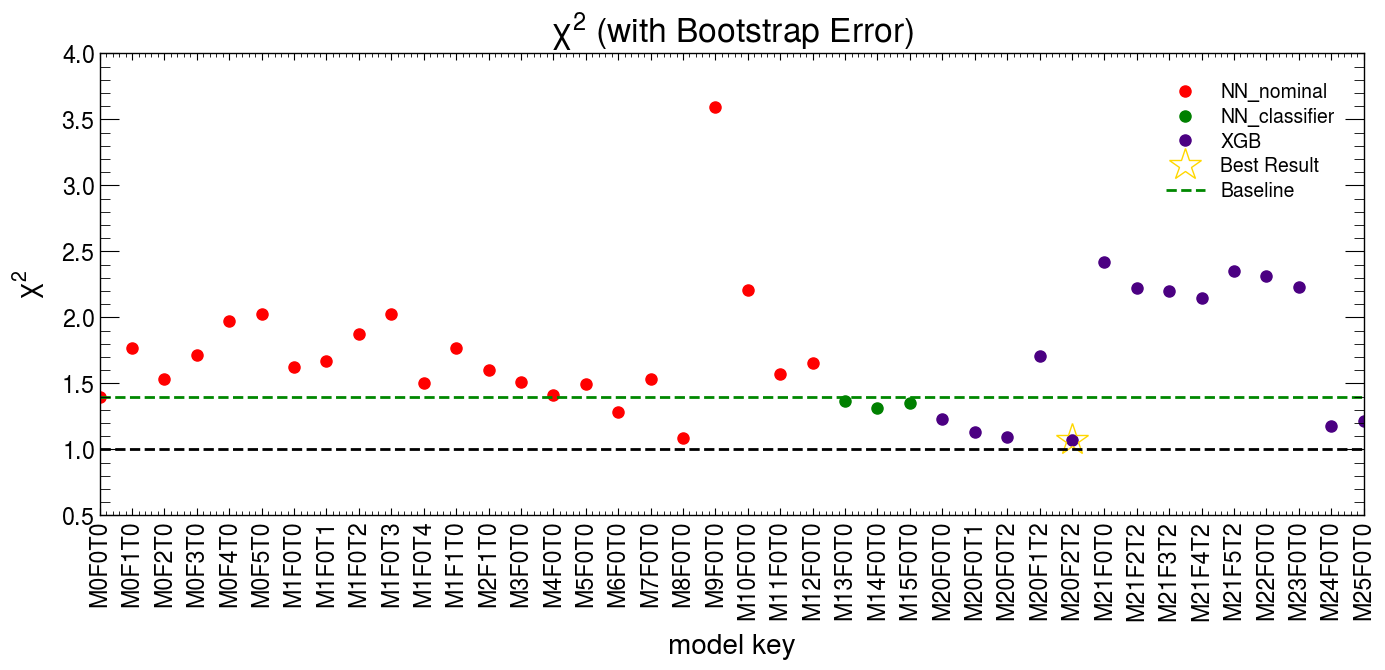

In [183]:
plt.subplots(figsize=(16, 6))
nn_nominal_count = 0
nn_classifier_count = 0
xgb_count = 0
for i, (k, v) in enumerate(chis2_bs_all.items()):
    if model_types[i] == "NN_nominal":
        if nn_nominal_count == 0:
            plt.plot(k, v, "o", color="red", label="NN_nominal")
            nn_nominal_count += 1
        else:
            plt.plot(k, v, "o", color="red")
    elif model_types[i] == "NN_classifier":
        if nn_classifier_count == 0:
            plt.plot(k, v, "o", color="green", label="NN_classifier")
            nn_classifier_count += 1
        else:
            plt.plot(k, v, "o", color="green")
    elif model_types[i] == "XGB":
        if xgb_count == 0:
            plt.plot(k, v, "o", color="indigo", label="XGB")
            xgb_count += 1
        else:
            plt.plot(k, v, "o", color="indigo")
chis2_bs_all_df = pd.DataFrame(
    {"model_key": chis2_bs_all.keys(), "chi2": chis2_bs_all.values()}
).sort_values(by="chi2", ascending=True)
plt.plot(
    chis2_bs_all_df.iloc[0, 0],
    chis2_bs_all_df.iloc[0, 1],
    "*",
    markersize=24,
    markeredgecolor="gold",
    markerfacecolor="none",
    label="Best Result",
)
plt.axhline(1, color="black", ls="--")
plt.axhline(chis2_bs_all["M0F0T0"], label="Baseline", ls="--")
plt.title(r"$\chi^2$ (with Bootstrap Error)")
plt.ylabel(r"$\chi^2$")
plt.xlabel("model key")
_ = plt.xticks(rotation=90)
plt.legend()

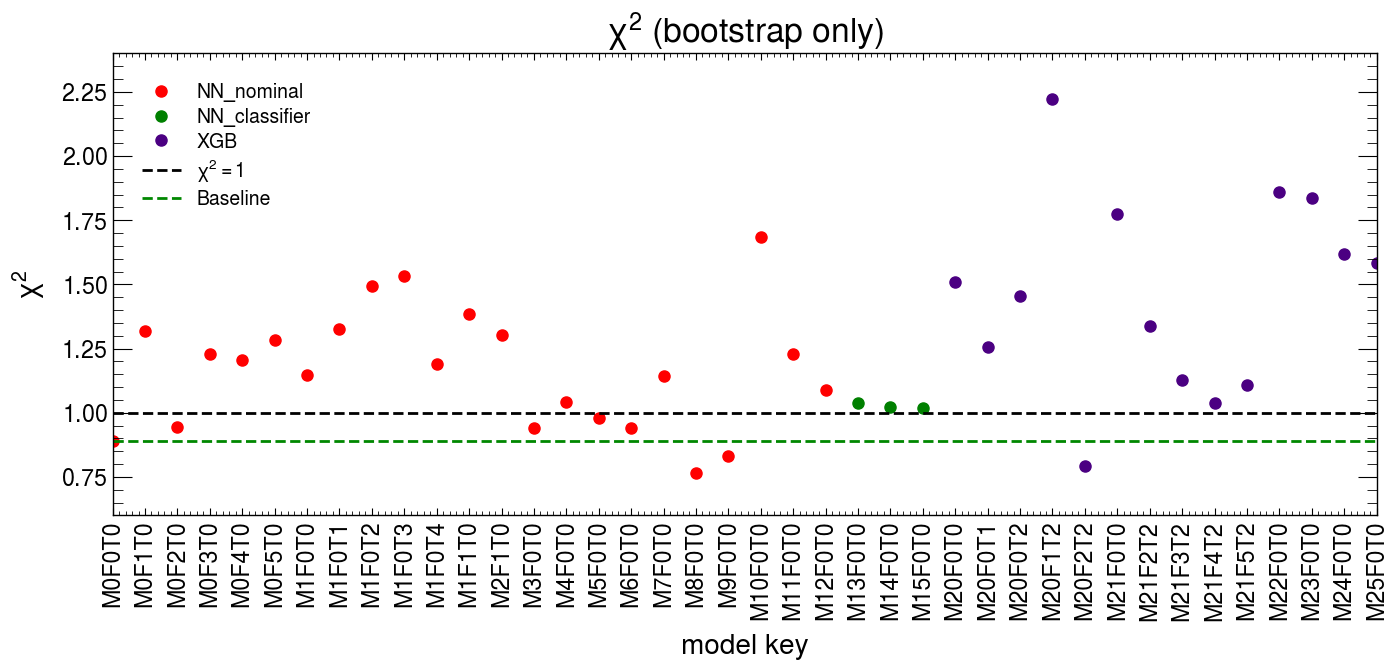

In [341]:
plt.subplots(figsize=(16,6))
nn_nominal_count=0
nn_classifier_count=0
xgb_count=0
for i, (k, v) in enumerate(chi2_2_bs_all.items()):
    if model_types[i] == 'NN_nominal':
        if nn_nominal_count == 0:
            plt.plot(k, v, 'o', color = 'red', label = 'NN_nominal')
            nn_nominal_count+=1
        else:
            plt.plot(k, v, 'o', color='red')
    elif model_types[i] == 'NN_classifier':
        if nn_classifier_count==0:
            plt.plot(k, v, 'o', color = 'green', label ='NN_classifier')
            nn_classifier_count+=1
        else:
            plt.plot(k, v, 'o', color = 'green')
    elif model_types[i] == 'XGB':
        if xgb_count==0:
            plt.plot(k, v, 'o', color = 'indigo', label = 'XGB')
            xgb_count+=1
        else:
            plt.plot(k, v, 'o', color='indigo')
#plt.plot(chis2_2_all_df.iloc[0,0], chis2_all_df.iloc[0, 1], '*', markersize=24, markeredgecolor='gold', markerfacecolor='none', label = 'Best Result')
plt.axhline(1, color='black', ls ='--', label = '$\chi^2 = 1$')
plt.axhline(chi2_2_bs_all["M0F0T0"], label = 'Baseline', ls = "--")
plt.title(r'$\chi^2$ (bootstrap only)')
plt.ylabel(r'$\chi^2$')
plt.xlabel('model key')
_=plt.xticks(rotation=90)
plt.legend()

### Including Shape Systematic Error in $\chi^2$

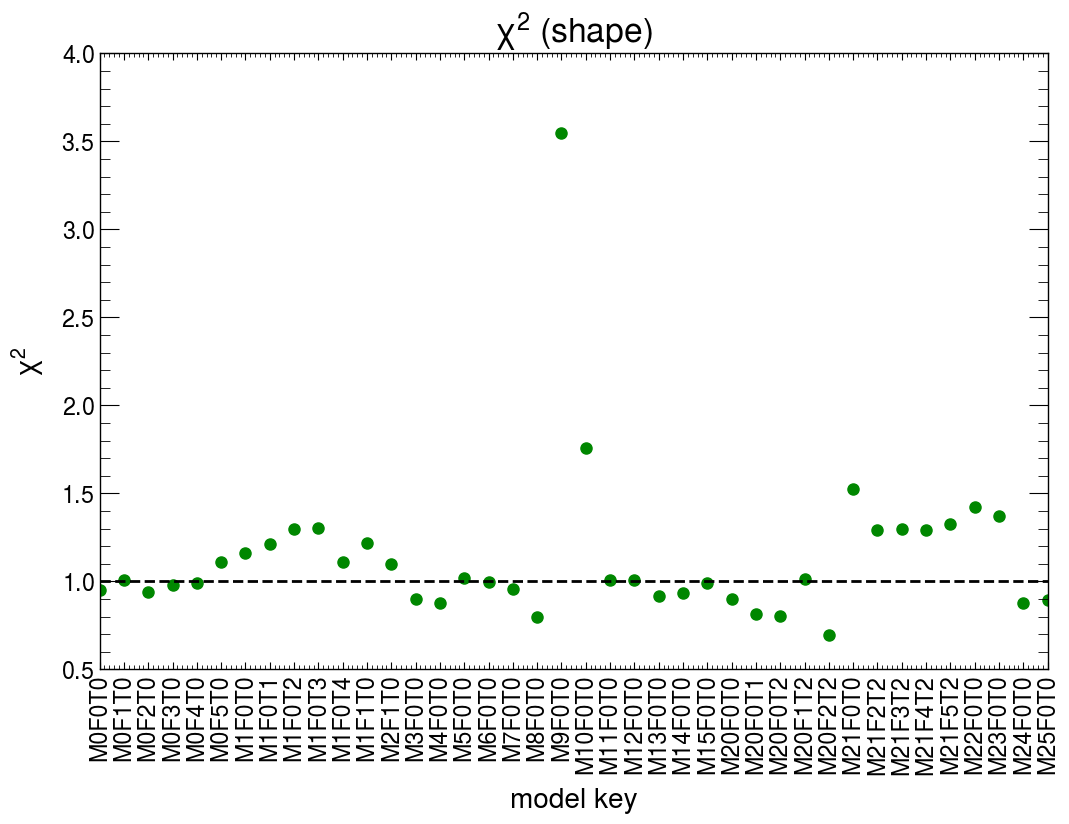

In [77]:
plt.subplots(figsize=(12, 8))
plt.plot(list(chis2_shape_all.keys()), list(chis2_shape_all.values()), 'o')
plt.axhline(1, color='black', ls = '--')
plt.title(r'$\chi^2$ (shape)')
plt.ylabel(r'$\chi^2$')
plt.xlabel('model key')
_=plt.xticks(rotation=90)

In [162]:
1-np.array(list((chis2_shape_all.values())))

array([ 0.04770942, -0.00788078,  0.05983259,  0.02300906,  0.00757536,
       -0.10770405, -0.16203412, -0.21240443, -0.30007705, -0.30409701,
       -0.11088475, -0.21737923, -0.09674375,  0.10099285,  0.12486352,
       -0.02133744,  0.00569502,  0.04318081,  0.20524558, -2.54806456,
       -0.75771444, -0.01055288, -0.00860098,  0.08277378,  0.06762826,
        0.00937283,  0.09961546,  0.18706119,  0.19833739, -0.01478033,
        0.30293623, -0.52313276, -0.28968783, -0.29848585, -0.29129884,
       -0.32387588, -0.42465561, -0.37155751,  0.12085619,  0.10865921])

In [159]:
np.ones(len(chis2_shape_all.values()))- chis2_shape_all.values()

TypeError: unsupported operand type(s) for -: 'float' and 'dict_values'

In [167]:
chis2_shape_all_df = pd.DataFrame(
    {
        "model_key": chis2_shape_all.keys(),
        "chi2": chis2_shape_all.values(),
        "diff": np.abs((1 - np.array(list(chis2_shape_all.values())))),
    }
)

In [168]:
chis2_shape_all_df.sort_values(by='diff')

model_key      chi2      diff
16    M6F0T0  0.994305  0.005695
4     M0F4T0  0.992425  0.007575
1     M0F1T0  1.007881  0.007881
22   M12F0T0  1.008601  0.008601
25   M15F0T0  0.990627  0.009373
21   M11F0T0  1.010553  0.010553
29   M20F1T2  1.014780  0.014780
15    M5F0T0  1.021337  0.021337
3     M0F3T0  0.976991  0.023009
17    M7F0T0  0.956819  0.043181
0     M0F0T0  0.952291  0.047709
2     M0F2T0  0.940167  0.059833
24   M14F0T0  0.932372  0.067628
23   M13F0T0  0.917226  0.082774
12    M2F1T0  1.096744  0.096744
26   M20F0T0  0.900385  0.099615
13    M3F0T0  0.899007  0.100993
5     M0F5T0  1.107704  0.107704
39   M25F0T0  0.891341  0.108659
10    M1F0T4  1.110885  0.110885
38   M24F0T0  0.879144  0.120856
14    M4F0T0  0.875136  0.124864
6     M1F0T0  1.162034  0.162034
27   M20F0T1  0.812939  0.187061
28   M20F0T2  0.801663  0.198337
18    M8F0T0  0.794754  0.205246
7     M1F0T1  1.212404  0.212404
11    M1F1T0  1.217379  0.217379
32   M21F2T2  1.289688  0.289688
34   M21F4T2  1.291299  0.291299
33   M21F3T2  1.298486  0.298486
8     M1F0T2  1.300077  0.300077
30   M20F2T2  0.697064  0.302936
9     M1F0T3  1.304097  0.304097
35   M21F5T2  1.323876  0.323876
37   M23F0T0  1.371558  0.371558
36   M22F0T0  1.424656  0.424656
31   M21F0T0  1.523133  0.523133
20   M10F0T0  1.757714  0.757714
19    M9F0T0  3.548065  2.548065

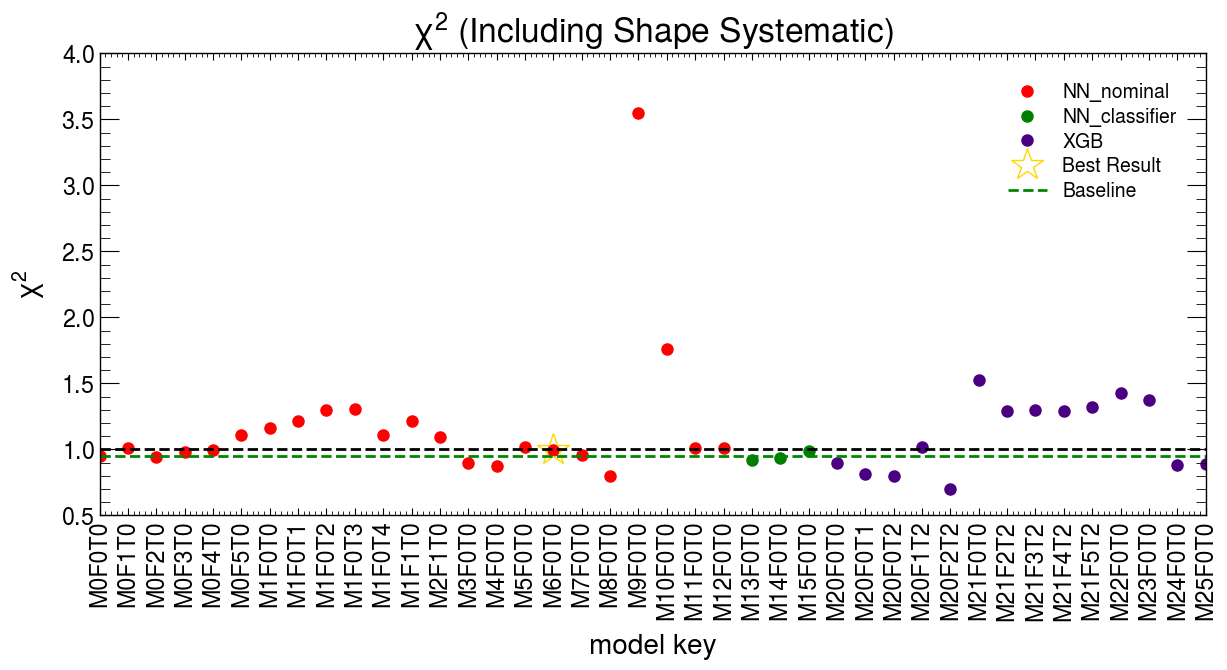

In [184]:
plt.subplots(figsize=(14, 6))
nn_nominal_count = 0
nn_classifier_count = 0
xgb_count = 0
for i, (k, v) in enumerate(chis2_shape_all.items()):
    if model_types[i] == "NN_nominal":
        if nn_nominal_count == 0:
            plt.plot(k, v, "o", color="red", label="NN_nominal")
            nn_nominal_count += 1
        else:
            plt.plot(k, v, "o", color="red")
    elif model_types[i] == "NN_classifier":
        if nn_classifier_count == 0:
            plt.plot(k, v, "o", color="green", label="NN_classifier")
            nn_classifier_count += 1
        else:
            plt.plot(k, v, "o", color="green")
    elif model_types[i] == "XGB":
        if xgb_count == 0:
            plt.plot(k, v, "o", color="indigo", label="XGB")
            xgb_count += 1
        else:
            plt.plot(k, v, "o", color="indigo")
chis2_shape_all_df = pd.DataFrame(
    {
        "model_key": chis2_shape_all.keys(),
        "chi2": chis2_shape_all.values(),
        "diff": np.abs(1 - np.array(list(chis2_shape_all.values()))),
    }
).sort_values(by="diff", ascending=True)
plt.plot(
    chis2_shape_all_df.iloc[0, 0],
    chis2_shape_all_df.iloc[0, 1],
    "*",
    markersize=24,
    markeredgecolor="gold",
    markerfacecolor="none",
    label = 'Best Result'
)
plt.axhline(1, color="black", ls="--")
plt.axhline(chis2_shape_all["M0F0T0"], label="Baseline", ls="--")
plt.title(r"$\chi^2$ (Including Shape Systematic)")
plt.ylabel(r"$\chi^2$")
plt.xlabel("model key")
_ = plt.xticks(rotation=90)
plt.legend()

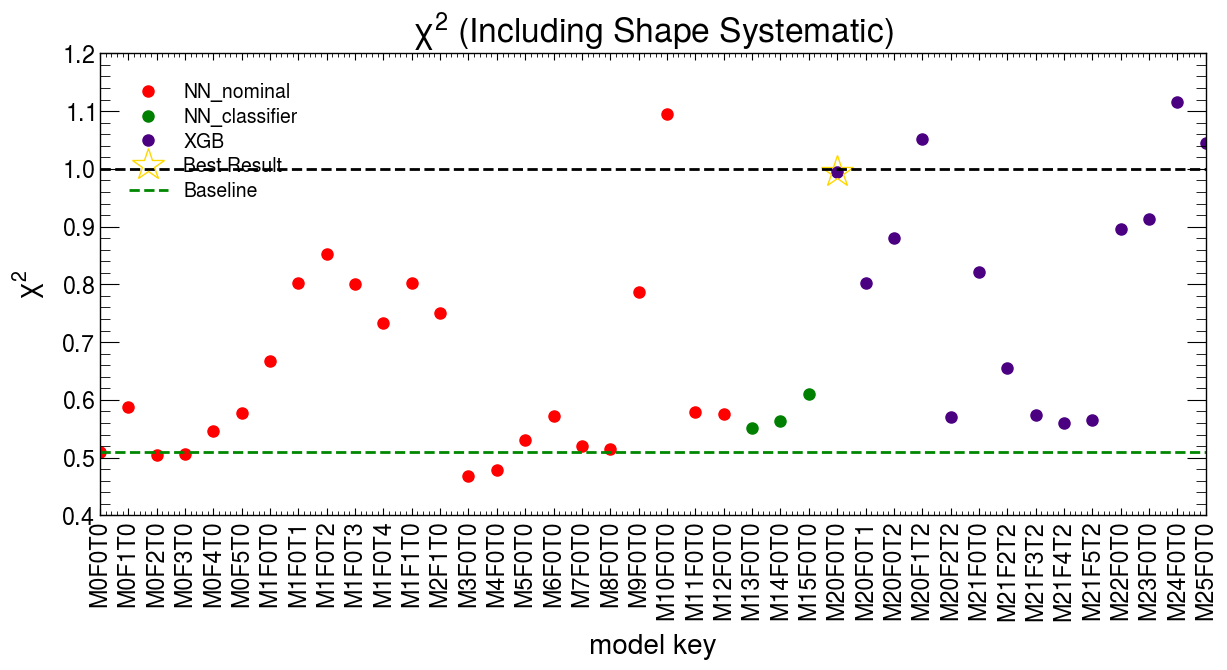

In [342]:
plt.subplots(figsize=(14, 6))
nn_nominal_count = 0
nn_classifier_count = 0
xgb_count = 0
for i, (k, v) in enumerate(chi2_2_shape_all.items()):
    if model_types[i] == "NN_nominal":
        if nn_nominal_count == 0:
            plt.plot(k, v, "o", color="red", label="NN_nominal")
            nn_nominal_count += 1
        else:
            plt.plot(k, v, "o", color="red")
    elif model_types[i] == "NN_classifier":
        if nn_classifier_count == 0:
            plt.plot(k, v, "o", color="green", label="NN_classifier")
            nn_classifier_count += 1
        else:
            plt.plot(k, v, "o", color="green")
    elif model_types[i] == "XGB":
        if xgb_count == 0:
            plt.plot(k, v, "o", color="indigo", label="XGB")
            xgb_count += 1
        else:
            plt.plot(k, v, "o", color="indigo")
chis2_shape_all_df = pd.DataFrame(
    {
        "model_key": chi2_2_shape_all.keys(),
        "chi2": chi2_2_shape_all.values(),
        "diff": np.abs(1 - np.array(list(chi2_2_shape_all.values()))),
    }
).sort_values(by="diff", ascending=True)
plt.plot(
    chis2_shape_all_df.iloc[0, 0],
    chis2_shape_all_df.iloc[0, 1],
    "*",
    markersize=24,
    markeredgecolor="gold",
    markerfacecolor="none",
    label = 'Best Result'
)
plt.axhline(1, color="black", ls="--")
plt.axhline(chi2_2_shape_all["M0F0T0"], label="Baseline", ls="--")
plt.title(r"$\chi^2$ (Including Shape Systematic)")
plt.ylabel(r"$\chi^2$")
plt.xlabel("model key")
_ = plt.xticks(rotation=90)
plt.legend()

# EARTH MOVER'S DISTANCE

In [277]:
emds

array([ 7.22773302,  5.35579265,  5.27972792, 12.65884198])

In [ ]:
plt.subplots(figsize=(16,6))
nn_nominal_count=0
nn_classifier_count=0
xgb_count=0
for i, (k, v) in enumerate(chis2_all.items()):
    if model_types[i] == 'NN_nominal':
        if nn_nominal_count == 0:
            plt.plot(k, v, 'o', color = 'red', label = 'NN_nominal')
            nn_nominal_count+=1
        else:
            plt.plot(k, v, 'o', color='red')
    elif model_types[i] == 'NN_classifier':
        if nn_classifier_count==0:
            plt.plot(k, v, 'o', color = 'green', label ='NN_classifier')
            nn_classifier_count+=1
        else:
            plt.plot(k, v, 'o', color = 'green')
    elif model_types[i] == 'XGB':
        if xgb_count==0:
            plt.plot(k, v, 'o', color = 'indigo', label = 'XGB')
            xgb_count+=1
        else:
            plt.plot(k, v, 'o', color='indigo')
plt.plot(chis2_all_df.iloc[0,0], chis2_all_df.iloc[0, 1], '*', markersize=24, markeredgecolor='gold', markerfacecolor='none', label = 'Best Result')
plt.axhline(1, color='black', ls ='--', label = '$\chi^2 = 1$')
plt.axhline(chis2_all["M0F0T0"], label = 'Baseline', ls = "--")
plt.title(r'$\chi^2$ (poisson only)')
plt.ylabel(r'$\chi^2$')
plt.xlabel('model key')
_=plt.xticks(rotation=90)
plt.legend()

# BOOTSTRAP ERRORS

In [78]:
model_bs_error = {}
model_shape_error = {}
histograms_mhh_2b = {}
bs_perc_err_2b = {}
shape_perc_err_2b = {}
be = np.linspace(250, 1200, 51)
x = 0.5 * (be[:-1] + be[1:])
for model in models_keys_16:
    print(model)

    weight_col = w_col(16, weight_label=model)
    weight_iqr_col = w_iqr(16, weight_label=model)
    mu_med = get_norm(df16, 16, weight_label=model)
    mu_IQR = get_norm_iqr(df16, 16, weight_label=model)
    bs_err = bs_error(
        df16,
        kr=2,
        be=be,
        W_med=weight_col,
        W_IQR=weight_iqr_col,
        mu_med=mu_med,
        mu_IQR=mu_IQR,
        feature="m_hh",
    )["h_err_bs_mag"]

    h_mhh_2b = histogram_2b(df16, "m_hh", 2, mu_med, weight_col, be)

    shape_err = shape_systematic(
        df16,
        "m_hh",
        2,
        be,
        CR_weights=w_col(16, weight_label=model),
        VR_weights=w_col(16, vr=True, weight_label=model),
    )['shape_err']

    model_bs_error[model] = np.abs(bs_err)
    model_shape_error[model] = shape_err
    histograms_mhh_2b[model] = h_mhh_2b["h_2b"]
    bs_perc_err_2b[model] = 100 * np.abs(bs_err) / h_mhh_2b["h_2b"]
    shape_perc_err_2b[model] = 100 * shape_err / h_mhh_2b['h_2b']

M0F0T0
M0F1T0
M0F2T0
M0F3T0
M0F4T0
M0F5T0
M1F0T0
M1F0T1
M1F0T2
M1F0T3
M1F0T4
M1F1T0
M2F1T0
M3F0T0
M4F0T0
M5F0T0
M6F0T0
M7F0T0
M8F0T0
M9F0T0
M10F0T0
M11F0T0
M12F0T0
M13F0T0
M14F0T0
M15F0T0
M20F0T0
M20F0T1
M20F0T2
M20F1T2
M20F2T2
M21F0T0
M21F2T2
M21F3T2
M21F4T2
M21F5T2
M22F0T0
M23F0T0
M24F0T0
M25F0T0


In [102]:
results_tests

{'model_bs_error': {'M0F0T0': array([ 3.116199  ,  8.49846491, 16.835077  , 23.76770021, 30.17639388,
         34.86258247, 37.77412345, 38.16967199, 34.44477903, 31.48784206,
         26.64637841, 22.60483736, 18.79948973, 15.77065502, 13.62787931,
         10.53331501,  9.07906262,  7.58588128,  6.83551718,  5.32743643,
          4.60144822,  4.70693764,  3.84692167,  3.27422254,  3.03666484,
          2.52156735,  2.48392272,  2.07196886,  1.68263764,  1.52636973,
          1.36995997,  1.29366427,  1.04801206,  0.90849164,  0.80783956,
          0.75380916,  0.59274009,  0.47987631,  0.37169325,  0.44787298,
          0.36805274,  0.25357455,  0.21898877,  0.22907102,  0.14698244,
          0.16832271,  0.13477728,  0.08792282,  0.11033814,  0.09341688]),
  'M0F1T0': array([ 3.17889723,  7.23792711, 12.91215761, 18.09994177, 23.56714914,
         27.00008943, 29.87084852, 30.10174294, 27.92032553, 24.57226884,
         21.94860886, 18.53926332, 16.18210888, 13.76725987, 12.05052649

In [101]:
pd.DataFrame(results_tests)

model_bs_error
M0F0T0   [3.1161990039466945, 8.49846491063997, 16.8350...
M0F1T0   [3.1788972301459193, 7.2379271074641585, 12.91...
M0F2T0   [2.444750535535076, 5.628648147251321, 7.50671...
M0F3T0   [2.0828509584269166, 5.0162324319002245, 6.660...
M0F4T0   [2.962634490468735, 6.819609225489479, 11.2689...
M0F5T0   [2.588896361419226, 6.160648856671561, 10.2703...
M10F0T0  [3.161296902105493, 8.41879877075665, 17.22251...
M11F0T0  [2.3393167283736953, 4.247595051840946, 8.0615...
M12F0T0  [3.8008596940122343, 8.237217292914409, 8.6524...
M13F0T0  [2.5199429959256205, 3.364127359093047, 4.6711...
M14F0T0  [3.6228136483367903, 5.34483765238001, 7.40672...
M15F0T0  [3.333094581467011, 7.323519938604656, 12.3172...
M1F0T0   [3.51556454574828, 7.487401110203416, 13.60830...
M1F0T1   [2.8673732618839645, 6.066388060895893, 9.7411...
M1F0T2   [3.3575662763218252, 7.530422544330679, 9.5460...
M1F0T3   [2.4702571604291257, 4.5065700716536465, 6.312...
M1F0T4   [3.235501203268057, 6.665530707870315, 9.50907...
M1F1T0   [1.8805076052374132, 2.9349765635046716, 4.179...
M20F0T0  [3.631226604239403, 5.0583496014777, 3.8213711...
M20F0T1  [4.103642901729531, 4.207238325459962, 5.35242...
M20F0T2  [3.380926394459485, 2.994790176989853, 3.59456...
M20F1T2  [3.419105478093323, 4.728713430321332, 4.93027...
M20F2T2  [3.969843609013998, 6.433680900794412, 9.78467...
M21F0T0  [3.16256395273191, 9.799375815952796, 0.370608...
M21F2T2  [3.712826057546931, 3.439455676161259, 3.66668...
M21F3T2  [5.6327563395432065, 7.1537067616650365, 10.74...
M21F4T2  [5.393209524544579, 6.833054407529837, 11.2085...
M21F5T2  [3.9454966387042294, 5.493054008263366, 9.1363...
M22F0T0  [2.8705083907123656, 5.730222160792576, 2.7156...
M23F0T0  [3.885825679142739, 6.440540545917938, 5.07098...
M24F0T0  [1.2128626489380383, 1.488297657287814, 1.3763...
M25F0T0  [3.9229549065771065, 4.275634544142339, 1.3872...
M2F1T0   [2.772750652709247, 5.8829159234140835, 9.6071...
M3F0T0   [2.811882534402644, 7.079799906565344, 11.7873...
M4F0T0   [2.7584414612241526, 5.58092542350567, 9.34395...
M5F0T0   [3.1271638869573724, 6.665947578524779, 10.045...
M6F0T0   [3.575674273236049, 6.3038400396855065, 10.968...
M7F0T0   [2.35514624353694, 5.267914812116608, 9.072807...
M8F0T0   [6.891069291882156, 9.814995865417798, 17.8614...
M9F0T0   [4.278106054032001, 14.686462761716466, 33.872...

In [104]:
results_tests = {}
results_tests['model_bs_error'] = model_bs_error
results_tests['model_shape_error'] = model_shape_error

In [106]:
pd.DataFrame(results_tests).to_pickle('test.pkl')

In [82]:
results['model_bs_error'] = model_bs_error

In [83]:
results

{'results_df':    model_key    metric      diff
 26   M20F0T0  0.995039  0.004961
 39   M25F0T0  1.044414  0.044414
 29   M20F1T2  1.051836  0.051836
 37   M23F0T0  0.912537  0.087463
 20   M10F0T0  1.094851  0.094851
 36   M22F0T0  0.895931  0.104069
 38   M24F0T0  1.115788  0.115788
 28   M20F0T2  0.879777  0.120223
 8     M1F0T2  0.853215  0.146785
 31   M21F0T0  0.821570  0.178430
 27   M20F0T1  0.802680  0.197320
 11    M1F1T0  0.802328  0.197672
 7     M1F0T1  0.801733  0.198267
 9     M1F0T3  0.800197  0.199803
 19    M9F0T0  0.786283  0.213717
 12    M2F1T0  0.750763  0.249237
 10    M1F0T4  0.732362  0.267638
 6     M1F0T0  0.666593  0.333407
 32   M21F2T2  0.654836  0.345164
 25   M15F0T0  0.609890  0.390110
 1     M0F1T0  0.588353  0.411647
 21   M11F0T0  0.579200  0.420800
 5     M0F5T0  0.576727  0.423273
 22   M12F0T0  0.576237  0.423763
 33   M21F3T2  0.573031  0.426969
 16    M6F0T0  0.572253  0.427747
 30   M20F2T2  0.569872  0.430128
 35   M21F5T2  0.565752  0.434248


In [81]:
model_bs_error

{'M0F0T0': array([ 3.116199  ,  8.49846491, 16.835077  , 23.76770021, 30.17639388,
        34.86258247, 37.77412345, 38.16967199, 34.44477903, 31.48784206,
        26.64637841, 22.60483736, 18.79948973, 15.77065502, 13.62787931,
        10.53331501,  9.07906262,  7.58588128,  6.83551718,  5.32743643,
         4.60144822,  4.70693764,  3.84692167,  3.27422254,  3.03666484,
         2.52156735,  2.48392272,  2.07196886,  1.68263764,  1.52636973,
         1.36995997,  1.29366427,  1.04801206,  0.90849164,  0.80783956,
         0.75380916,  0.59274009,  0.47987631,  0.37169325,  0.44787298,
         0.36805274,  0.25357455,  0.21898877,  0.22907102,  0.14698244,
         0.16832271,  0.13477728,  0.08792282,  0.11033814,  0.09341688]),
 'M0F1T0': array([ 3.17889723,  7.23792711, 12.91215761, 18.09994177, 23.56714914,
        27.00008943, 29.87084852, 30.10174294, 27.92032553, 24.57226884,
        21.94860886, 18.53926332, 16.18210888, 13.76725987, 12.05052649,
         9.93594199,  9.15463

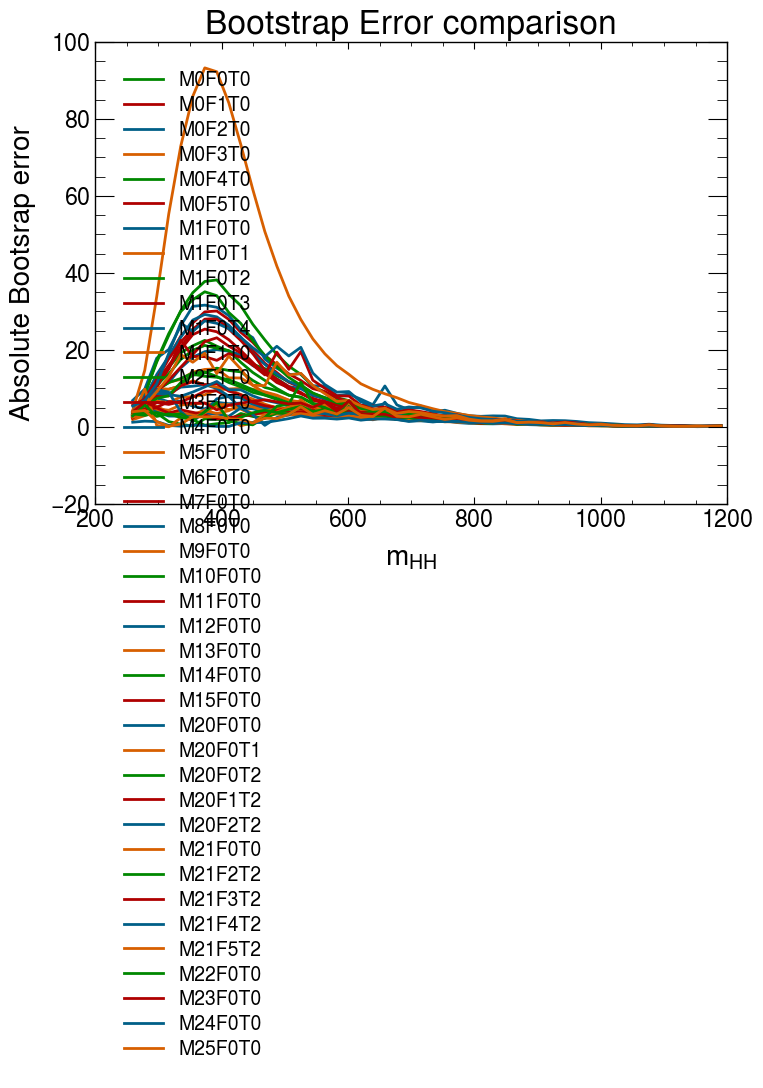

In [80]:
for key in model_bs_error.keys():
    plt.plot(x, np.abs(model_bs_error[key]), label = key)
plt.legend()
plt.xlabel(r'$m_{HH}$')
plt.ylabel('Absolute Bootsrap error')
_=plt.title('Bootstrap Error comparison')

In [358]:
for i in range(20):
    print(i%5)

0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4


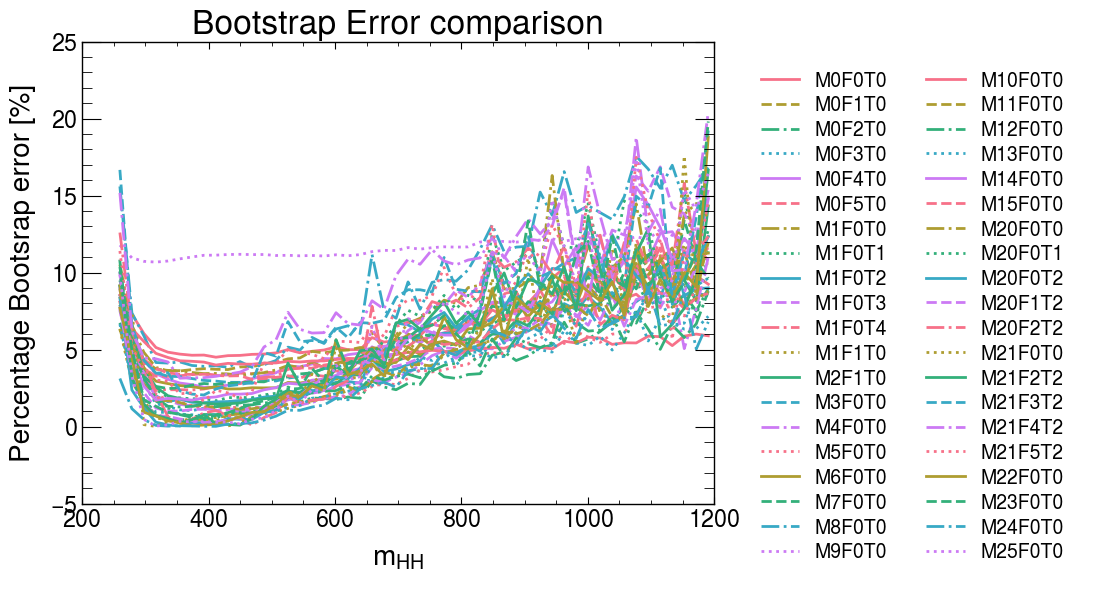

In [188]:
NUM_COLORS = 5
LINE_STYLES = ['solid', 'dashed', 'dashdot', 'dotted']
NUM_STYLES = len(LINE_STYLES)
clrs = sns.color_palette('husl', n_colors=NUM_COLORS)

for i, key in enumerate(model_bs_error.keys()):
    l = plt.plot(x, np.abs(bs_perc_err_2b[key]), label = key)
    l[0].set_color(clrs[i%NUM_COLORS])
    l[0].set_linestyle(LINE_STYLES[i%NUM_STYLES])
plt.legend(bbox_to_anchor=(1.60, 1), loc='upper right', ncol = 2)
plt.xlabel(r'$m_{HH}$')
plt.ylabel('Percentage Bootsrap error [%]')
_=plt.title('Bootstrap Error comparison')

In [194]:
h_err.shape

(40, 50)

In [231]:
from matplotlib import cm

In [232]:
evenly_spaced_interval = np.linspace(0, 1, 5)
colors = [cm.rainbow(x) for x in evenly_spaced_interval]

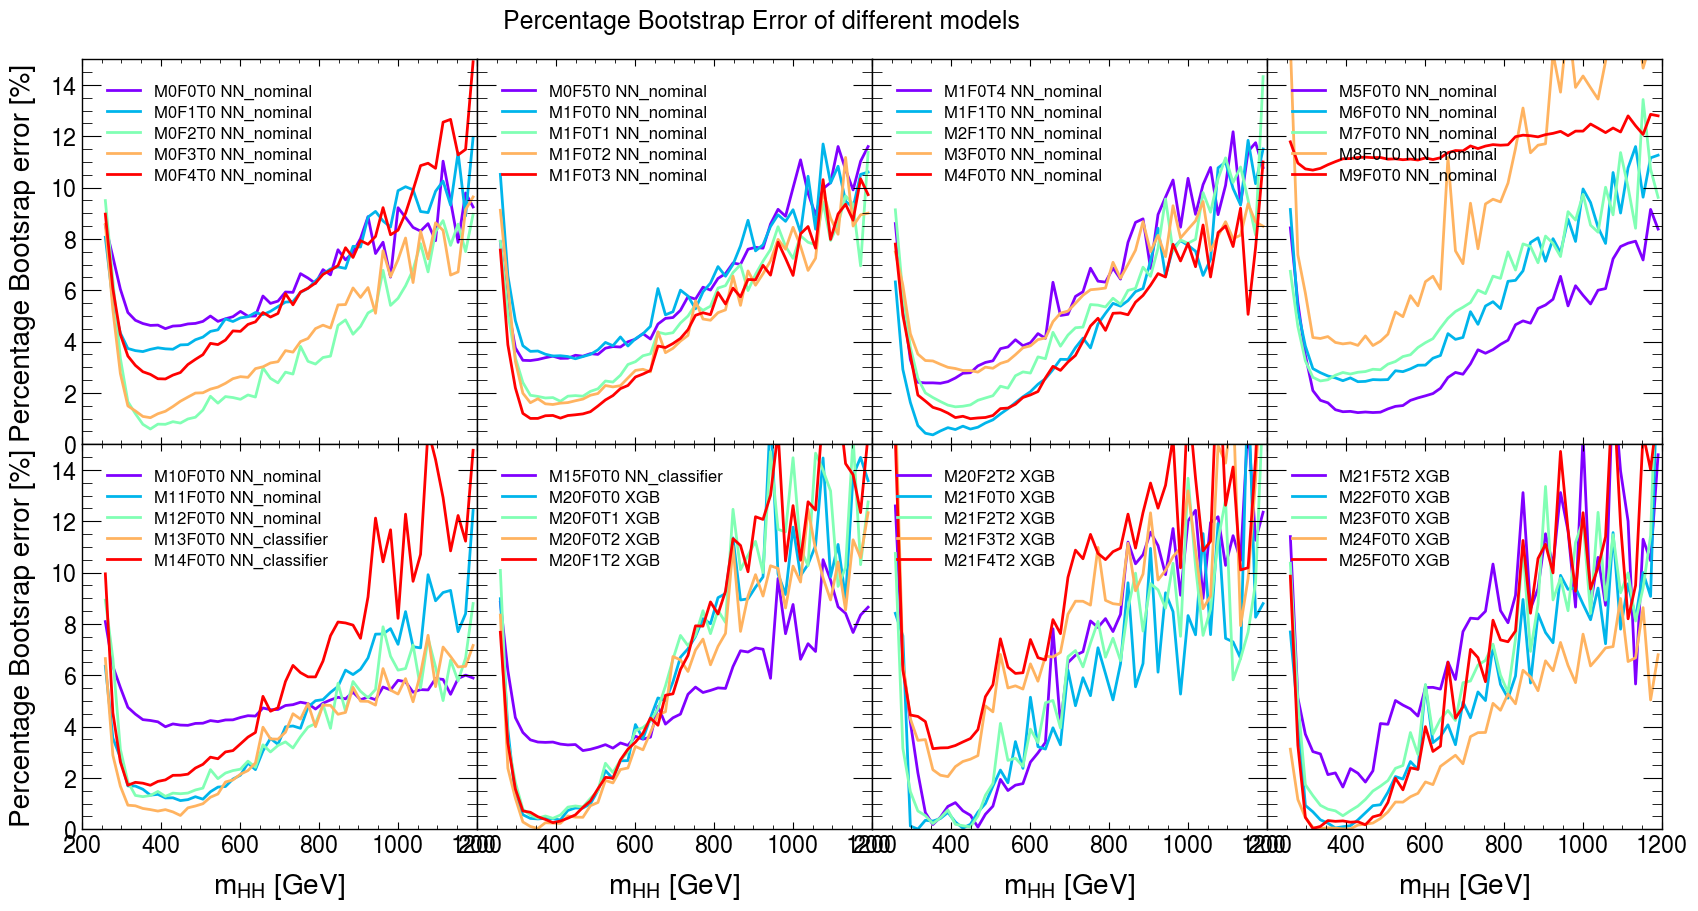

In [256]:
f, ax = plt.subplots(2,4, figsize= (20,10), sharex=True, sharey=True)


h_err = np.array(list(bs_perc_err_2b.values()))
for i, (m_k, m_t) in enumerate(zip(models_keys_16, model_types)):
    label = m_k + ' ' + m_t
    if i < 5:
        _ = ax[0,0].plot(x, h_err[i, :], label = label, color=colors[i%5])
        ax[0,0].set_ylim(0, 15)
    elif i >= 5 and i < 10:
        _ = ax[0,1].plot(x, h_err[i, :], label = label, color=colors[i%5])
    elif i >= 10 and i < 15:
        _ = ax[0,2].plot(x, h_err[i, :], label = label, color =colors[i%5])
    elif i >= 15 and i < 20:
        _ = ax[0,3].plot(x, h_err[i, :], label = label, color = colors[i%5])
    elif i >= 20 and i < 25:
        _ = ax[1,0].plot(x, h_err[i, :], label = label, color = colors[i%5])
    elif i >= 25 and i < 30:
        _ = ax[1,1].plot(x, h_err[i, :], label = label, color = colors[i%5])
    elif i >= 30 and i < 35:
        _ = ax[1,2].plot(x, h_err[i, :], label = label, color = colors[i%5])
    elif i >= 35 and i < 40:
        _ = ax[1,3].plot(x, h_err[i, :], label = label, color = colors[i%5])

for i in range(2):
    for j in range(4):
        ax[i,j].legend(loc = 'upper left', fontsize = 12)
        
plt.subplots_adjust(wspace=0, hspace=0)
ax[0,0].set_ylabel('Percentage Bootsrap error [%]')
ax[1,0].set_ylabel('Percentage Bootsrap error [%]')
ax[1,0].set_xlabel(r'$m_{HH}$ [GeV]')
ax[1,1].set_xlabel(r'$m_{HH}$ [GeV]')
ax[1,2].set_xlabel(r'$m_{HH}$ [GeV]')
ax[1,3].set_xlabel(r'$m_{HH}$ [GeV]')
_ = f.suptitle('Percentage Bootstrap Error of different models', fontsize=18)

## 

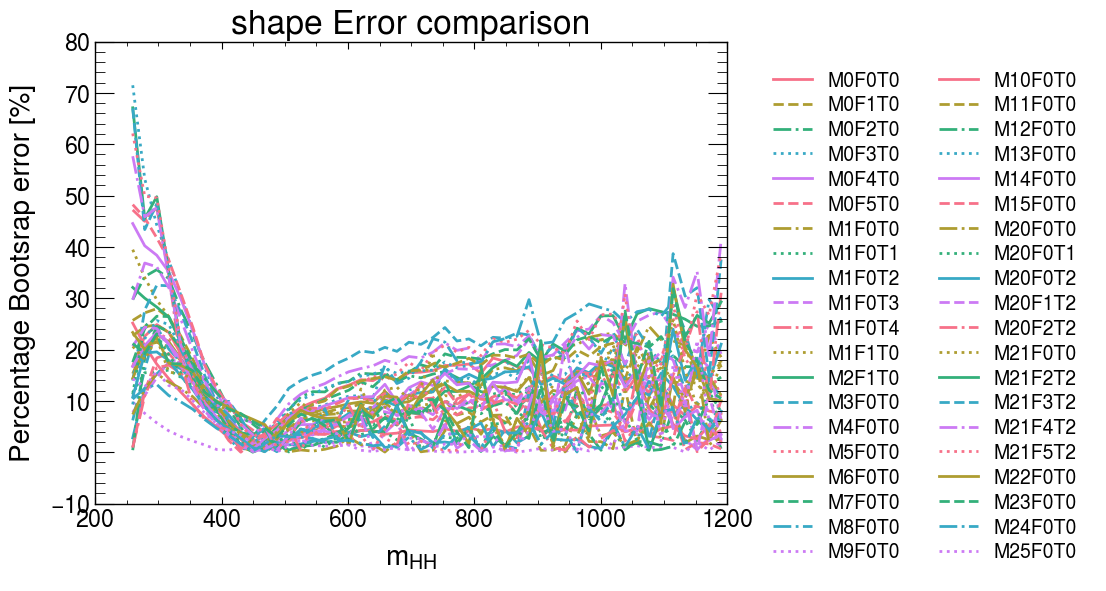

In [187]:
NUM_COLORS = 5
LINE_STYLES = ['solid', 'dashed', 'dashdot', 'dotted']
NUM_STYLES = len(LINE_STYLES)
clrs = sns.color_palette('husl', n_colors=NUM_COLORS)

for i, key in enumerate(model_bs_error.keys()):
    l = plt.plot(x, np.abs(shape_perc_err_2b[key]), label = key)
    l[0].set_color(clrs[i%NUM_COLORS])
    l[0].set_linestyle(LINE_STYLES[i%NUM_STYLES])
plt.legend(bbox_to_anchor=(1.60, 1), loc='upper right', ncol=2)
plt.xlabel(r'$m_{HH}$')
plt.ylabel('Percentage Bootsrap error [%]')
_=plt.title('shape Error comparison')

# DEBUG

**what is the perfect wasserstein distance?**

In [252]:
mu = np.random.normal(0, 1, 1000000)
nu = np.random.normal(1, 1, 1000000)

In [253]:
h_mu,be = np.histogram(mu, bins = 50,density=True)
h_nu, _ = np.histogram(nu, bins=be, density=True)

In [254]:
wasserstein_distance(mu,nu)

0.9994550275729673

In [255]:
wasserstein_distance(h_mu, h_nu)

0.0026868106626457074

In [247]:
e

NameError: name 'e' is not defined

**Some error building dicts**

In [284]:
mydict= {}

In [285]:
numbers= [1, 2, 3, 4]

In [286]:
mydict['key'] = numbers

In [287]:
mydict

{'key': [1, 2, 3, 4]}